# Predicting NFL Game Stats

## Predicting QB Passing Yards in Game<br>
  
In this initial version of this code, I will attempt to predict QB passing yards in a regular season game.  My plan is to expand this code to predict other stats in a regular season OR postseason game (rushing yards, total score, etc.).  
<br>
I will use play-by-play data from the `nfl_data_py` Python package  
<br>
**Credit to *Tim Bryan* for inspiring this project and giving a general framework of how to approach it**

In [1]:
import warnings
import numpy as np
import pandas as pd
import nfl_data_py as nfl
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interactive, BoundedFloatText, IntText, ToggleButtons, Layout

print(np.__version__, pd.__version__, '\n')

## Turn off max columns for Pandas DataFrame
pd.set_option('display.max_columns', None)

pd.set_option('display.max_colwidth', None)

## View the column names of the NFL play-by-play data table 
for colname in nfl.see_pbp_cols():
    print(colname)

2.2.3 2.2.3 

play_id
game_id
old_game_id
home_team
away_team
season_type
week
posteam
posteam_type
defteam
side_of_field
yardline_100
game_date
quarter_seconds_remaining
half_seconds_remaining
game_seconds_remaining
game_half
quarter_end
drive
sp
qtr
down
goal_to_go
time
yrdln
ydstogo
ydsnet
desc
play_type
yards_gained
shotgun
no_huddle
qb_dropback
qb_kneel
qb_spike
qb_scramble
pass_length
pass_location
air_yards
yards_after_catch
run_location
run_gap
field_goal_result
kick_distance
extra_point_result
two_point_conv_result
home_timeouts_remaining
away_timeouts_remaining
timeout
timeout_team
td_team
td_player_name
td_player_id
posteam_timeouts_remaining
defteam_timeouts_remaining
total_home_score
total_away_score
posteam_score
defteam_score
score_differential
posteam_score_post
defteam_score_post
score_differential_post
no_score_prob
opp_fg_prob
opp_safety_prob
opp_td_prob
fg_prob
safety_prob
td_prob
extra_point_prob
two_point_conversion_prob
ep
epa
total_home_epa
total_away_epa
total_

These are the initial columns I am selecting to predict passing yards with (very likely to change and be reordered in a more logical way):  
<br>
`'passer_player_name',
'season',
'season_type',
'week',
'home_team',
'away_team',
'posteam',
'posteam_type',
'defteam',      
'desc',
'play_type',
'pass_attempt',
'incomplete_pass',
'complete_pass',
'pass_oe',
'cpoe',
'passing_yards',
'air_yards',
'yards_after_catch',
'pass_touchdown',
'interception',
'fumble_lost',
'fumbled_1_team', 
'fumbled_2_team',
'fumble_recovery_1_team',
'fumble_recovery_2_team',
'qb_hit',
'sack',
'touchback',
'penalty',
'penalty_team',
'penalty_yards',
'epa',
'wpa',
'home_score',
'away_score'`

In [2]:
## Creating a list of columns to use for the QB data
## I want to include "roof," "temp," and "wind" but a lot of the data is missing. 
## "Roof" is missing by far the least (53 games all in 2021) of the three, and can be populated and used with some extra time
pbp_columns = [
    'passer_player_name',
    'season',
    'season_type',
    'week',
    'home_team',
    'away_team',
    'posteam',
    'posteam_type',
    'defteam',
    #'game_seconds_remaining',
    'desc',
    'play_type',
    'pass_attempt',
    'incomplete_pass',
    'complete_pass',
    'pass_oe',
    'cpoe',
    'passing_yards',
    'air_yards',
    'yards_after_catch',
    'pass_touchdown',
    'interception',
    'fumble_lost',
    'fumbled_1_team', 
    'fumbled_2_team',
    'fumble_recovery_1_team',
    'fumble_recovery_2_team',
    'qb_hit',
    'sack',
    'touchback',
    'penalty',
    'penalty_team',
    'penalty_yards',
    'epa',
    'wpa',
    'home_score',
    'away_score'
]

seasons = range(2006, 2024)

In [3]:
## Importing and displaying the selected play-by-play data
pbp = nfl.import_pbp_data(seasons, pbp_columns, include_participation=False) ## The keyword argument is default True.
## However, looking at the source code, the default would cause another file to be read in (pbp_participation) and
## merged with the play-by-play data. Unfortunately, the merge is done on the play-by-play columns "play_id" and "game_id"
## which I do not read in here, causing the merge and ultimate import to fail. The pbp_participation files only exist from 
## 2016 on, so any play-by-play files from 2016 on weren't being imported. 
print()

## nfl_data_py loads other columns that don't appear to be listed via see_pbp_cols(), so setting to only the columns I want
pbp = pbp[pbp_columns]

print(pbp.shape)

# pbp.head(180)
display(pbp)

2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.

(857073, 36)


,passer_player_name,season,season_type,week,home_team,away_team,posteam,posteam_type,defteam,desc,play_type,pass_attempt,incomplete_pass,complete_pass,pass_oe,cpoe,passing_yards,air_yards,yards_after_catch,pass_touchdown,interception,fumble_lost,fumbled_1_team,fumbled_2_team,fumble_recovery_1_team,fumble_recovery_2_team,qb_hit,sack,touchback,penalty,penalty_team,penalty_yards,epa,wpa,home_score,away_score
0,None,2006,REG,1,CAR,ATL,None,None,None,GAME,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,NaN,NaN,0.0,NaN,None,NaN,-0.000000,-0.000000,6,20
1,None,2006,REG,1,CAR,ATL,ATL,away,CAR,"7-J.Baker kicks 75 yards from CAR 30 to ATL -5. 20-A.Rossum to ATL 33 for 38 yards (7-J.Baker, 31-R.Marshall).",kickoff,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,0.892853,0.017605,6,20
2,None,2006,REG,1,CAR,ATL,ATL,away,CAR,"(14:54) 28-W.Dunn right tackle to ATL 38 for 5 yards (99-M.Kemoeatu, 77-K.Jenkins).",run,0.0,0.0,0.0,-44.816696,NaN,NaN,NaN,NaN,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,0.119106,0.002342,6,20
3,None,2006,REG,1,CAR,ATL,ATL,away,CAR,(14:18) 28-W.Dunn right end to ATL 37 for -1 yards (36-S.Williams).,run,0.0,0.0,0.0,-43.687210,NaN,NaN,NaN,NaN,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,-0.851534,-0.023510,6,20
4,M.Vick,2006,REG,1,CAR,ATL,ATL,away,CAR,(13:33) (Shotgun) 7-M.Vick pass short right to 83-A.Crumpler to ATL 47 for 10 yards (31-R.Marshall).,pass,1.0,0.0,1.0,3.369230,41.941399,10.0,9.0,1.0,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,1.862235,0.043966,6,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857068,None,2023,POST,22,KC,SF,KC,home,SF,(2:07) (Shotgun) 15-P.Mahomes scrambles up the middle to SF 13 for 19 yards (31-T.Gipson).,run,0.0,0.0,0.0,81.741051,NaN,NaN,NaN,NaN,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,1.728891,0.209521,25,22
857069,None,2023,POST,22,KC,SF,KC,home,SF,(1:26) (Shotgun) 10-I.Pacheco up the middle to SF 10 for 3 yards (90-K.Givens).,run,0.0,0.0,0.0,-31.014399,NaN,NaN,NaN,NaN,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,-0.330699,-0.007961,25,22
857070,P.Mahomes,2023,POST,22,KC,SF,KC,home,SF,(:50) (Shotgun) 15-P.Mahomes pass short middle to 87-T.Kelce to SF 3 for 7 yards (27-J.Brown; 97-N.Bosa).,pass,1.0,0.0,1.0,39.959972,16.130001,7.0,-2.0,9.0,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,-0.637115,0.021764,25,22
857071,P.Mahomes,2023,POST,22,KC,SF,KC,home,SF,"(:06) (Shotgun) 15-P.Mahomes pass short right to 12-M.Hardman for 3 yards, TOUCHDOWN.",pass,1.0,0.0,1.0,37.675518,32.141994,3.0,2.0,1.0,1.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,3.102806,0.128360,25,22


In [4]:
## Allows me to check for unexpected NA values in a DataFrame column as well as 
## helps me know what I may be dropping and why
def check_cols_for_NAs(df, cols, extra_disp_cols=[], which='passer', raise_errors=True):
    print('Columns to check for NA values: ', cols)
    print()
    
    cols_isna = df[cols].isna().any(axis=0) ## DataFrame.isnull is an alias for DataFrame.isna
                                            ## Returns a Series where the indexes are the column names of the main DataFrame
                                            ## The Series values are a Boolean indicating if the column in the main DataFrame
                                            ## contains NA values (None or NaN)
                
    cols_wNA = cols_isna[cols_isna].index   ## Uses Boolean indexing to return the Series indexes corresponding to a "True" value
    
    if len(cols_wNA) > 0:
        for colname in cols_wNA:
            
            if which == 'passer':
                display_cols = ['player_name',
                                'season', 
                                'week', 
                                'matchup', 
                                'posteam', 
                                'posteam_home',
                                'defteam'
                               ] 
                
            elif which == 'defense':
                display_cols = ['defteam',
                                'season', 
                                'week', 
                                'matchup',  
                                'defteam_home'
                               ] 
            
            display_cols += extra_disp_cols
            
            if colname in display_cols:
                display_cols.remove(colname) ## For general knowledge, removes the *first occurence* of the element
            display_cols.append(colname) ## Will display the offending column as the last column of the DataFrame subset
            
            display(df[df[colname].isna()][display_cols])
            
            print('Number of rows with NA value in column "{}": '.format(colname), end='')
            print(df[df[colname].isna()].shape[0])
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
        if raise_errors:
            raise ValueError(
                '''{} column(s) in the DataFrame have NA values (None or NaN).

                See above displayed DataFrame subsets'''
                .format(cols_wNA.values)
            )
        else:
            warnings.warn(
                '''{} column(s) in the DataFrame have NA values (None or NaN).

                See above displayed DataFrame subsets'''
                .format(cols_wNA.values)
            )
            
    else:
        print('NO NA VALUES DETECTED :)')
        print('\n\n')
        return
            
## Currently only works when columns are appended to the existing DataFrame
def reorder_columns(df, added_cols, after_which_col):
    cols = df.columns.to_list()
    insert_idx = cols.index(after_which_col) + 1
    reordered_cols = cols[:insert_idx] + added_cols + cols[insert_idx:-len(added_cols)]
    
    return reordered_cols

In [5]:
## Reducing the play-by-play DataFrame down to regular season (season_type=REG) data only
pbp_reg = pbp[pbp['season_type'] == 'REG'].drop(columns='season_type')
del(pbp)

## Removing play_type=None rows - having checked that in all cases (aside from MAYBE a mismarked play_type on a play that
## occured with a *declined* penalty - at worst would be ~130 rows) a play_type=None really is not a mismarked play but a
## e.g. timeout, beginning/end of game/quarter/half, listing of team captains, suspension/resumption of game, two-minute warning, etc.

# strings = '^game|^end|^two-minute warning|^timeout|captains|captians|suspended|resumed'
# pbp_reg['desc'] = pbp_reg['desc'].str.strip()
# pbp_reg = pbp_reg[~pbp_reg['desc'].str.contains(strings, case=False)]
pbp_reg = pbp_reg[~pbp_reg['play_type'].isna()]

## In an effort to avoid having NA values in "posteam," "posteam_home," and "defteam" columns before grouping
## (even though grouping can drop NA values), I am removing certain events (ex. timeouts)
## ^ denotes the pattern is checked for at the beginning of the string
pbp_reg['desc'] = pbp_reg['desc'].str.strip()
pbp_reg = pbp_reg[~pbp_reg['desc'].str.contains('^timeout', case=False)] ## Has "play_type" of "no_play"

## Adding column where the two teams playing against each other are both listed - will be used in future grouping tasks
pbp_reg['matchup'] = pbp_reg['home_team'] + '-' + pbp_reg['away_team']

## Reordering the columns
## Places "matchup" after "week" and removes "matchup" from the end
reordered_columns = reorder_columns(pbp_reg, ['matchup'], 'week')
pbp_reg = pbp_reg[reordered_columns]

## Setting the "posteam_type" values of "home" and "away" to 1 (home team = True) and 0 (home team = False), respectively.
pbp_reg.loc[pbp_reg['posteam_type'] == 'home', 'posteam_type'] = 1
pbp_reg.loc[pbp_reg['posteam_type'] == 'away', 'posteam_type'] = 0

## Renaming "passer_player_name" column to a more generic name for when I expand and generalize this code more
## Renaming "posteam_type" column to "posteam_home" to better reflect its new Boolean nature (1=home team, 0=away team)
pbp_reg.rename(columns={'passer_player_name': 'player_name', 'posteam_type': 'posteam_home'}, inplace=True)

## Columns to check initially for missing values. 
## "season," "week," "home_team," "away_team," "posteam," and "play_type" are the most important at this moment
## because the DataFrame will next be grouped by "season," "week," "matchup (defined with "home_team" and "away_team")," and "posteam"
## "play_type" is used in an aggregation function next as well. 
## It is not necessary at the moment to check "posteam_home" and "defteam." They are included sort of for completeness.

cols_to_check = ['season', 'week', 'home_team', 'away_team', 'posteam', 'posteam_home', 'defteam', 'play_type']

check_cols_for_NAs(pbp_reg, cols_to_check, 
                   extra_disp_cols=['desc', 'play_type', 'penalty', 'penalty_team', 'penalty_yards'], 
                   raise_errors=False)

pbp_reg.head()

Columns to check for NA values:  ['season', 'week', 'home_team', 'away_team', 'posteam', 'posteam_home', 'defteam', 'play_type']

NO NA VALUES DETECTED :)





,player_name,season,week,matchup,home_team,away_team,posteam,posteam_home,defteam,desc,play_type,pass_attempt,incomplete_pass,complete_pass,pass_oe,cpoe,passing_yards,air_yards,yards_after_catch,pass_touchdown,interception,fumble_lost,fumbled_1_team,fumbled_2_team,fumble_recovery_1_team,fumble_recovery_2_team,qb_hit,sack,touchback,penalty,penalty_team,penalty_yards,epa,wpa,home_score,away_score
1,None,2006,1,CAR-ATL,CAR,ATL,ATL,0,CAR,"7-J.Baker kicks 75 yards from CAR 30 to ATL -5. 20-A.Rossum to ATL 33 for 38 yards (7-J.Baker, 31-R.Marshall).",kickoff,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,0.892853,0.017605,6,20
2,None,2006,1,CAR-ATL,CAR,ATL,ATL,0,CAR,"(14:54) 28-W.Dunn right tackle to ATL 38 for 5 yards (99-M.Kemoeatu, 77-K.Jenkins).",run,0.0,0.0,0.0,-44.816696,NaN,NaN,NaN,NaN,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,0.119106,0.002342,6,20
3,None,2006,1,CAR-ATL,CAR,ATL,ATL,0,CAR,(14:18) 28-W.Dunn right end to ATL 37 for -1 yards (36-S.Williams).,run,0.0,0.0,0.0,-43.687210,NaN,NaN,NaN,NaN,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,-0.851534,-0.023510,6,20
4,M.Vick,2006,1,CAR-ATL,CAR,ATL,ATL,0,CAR,(13:33) (Shotgun) 7-M.Vick pass short right to 83-A.Crumpler to ATL 47 for 10 yards (31-R.Marshall).,pass,1.0,0.0,1.0,3.369230,41.941399,10.0,9.0,1.0,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,1.862235,0.043966,6,20
5,None,2006,1,CAR-ATL,CAR,ATL,ATL,0,CAR,"(12:58) 7-M.Vick pass incomplete short left to 12-M.Jenkins. PENALTY on CAR-58-T.Davis, Roughing the Passer, 15 yards, enforced at ATL 47 - No Play.",no_play,0.0,0.0,0.0,55.721855,NaN,NaN,NaN,NaN,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,1.0,CAR,15.0,1.110637,0.067985,6,20


In [6]:
print(pbp_reg['play_type'].unique())

['kickoff' 'run' 'pass' 'no_play' 'field_goal' 'punt' 'extra_point'
 'qb_kneel' 'qb_spike']


### Passer and Passer's Team Data Preprocessing  and Feature Engineering

#### Passer's Team<br>

Column names for full team (not just passer) stats have **\_team** in them.

In [7]:
# cols_to_disp = ['season', 'week', 'matchup', 'posteam', 'defteam', 'desc', 'play_type', 'interception', 'touchback',
#                 'fumble_lost', 'fumbled_1_team', 'fumbled_2_team', 'fumble_recovery_1_team', 'fumble_recovery_2_team']

# print(len(pbp_reg[(pbp_reg['fumble_lost'] == 1) & (pbp_reg['fumbled_1_team'].isna() == False)]), len(pbp_reg[(pbp_reg['fumble_lost'] == 1) & (pbp_reg['fumble_recovery_1_team'].isna() == False)]))
# print(len(pbp_reg[~pbp_reg['fumbled_2_team'].isna()]), len(pbp_reg[~pbp_reg['fumble_recovery_2_team'].isna()]))

# display(pbp_reg[(pbp_reg['fumble_lost'] == 1)][cols_to_disp])
# display(pbp_reg[(pbp_reg['fumble_lost'] == 1) & (pbp_reg['interception'] == 1)][cols_to_disp])
# display(pbp_reg[(pbp_reg['fumble_lost'] == 1) & (pbp_reg['fumbled_2_team'].isna() == False)][cols_to_disp])
# display(pbp_reg[(pbp_reg['fumble_lost'] == 1) & (pbp_reg['fumbled_1_team'].isna() == False) & (pbp_reg['fumble_recovery_1_team'].isna())][cols_to_disp])
# display(pbp_reg[(pbp_reg['fumble_lost'] == 1) & (pbp_reg['fumbled_2_team'].isna() == False) & (pbp_reg['fumble_recovery_2_team'].isna())][cols_to_disp])

In [8]:
def pass_percentage(play_type):
    num_pass_plays = len(play_type[play_type == 'pass'])
    num_run_plays  = len(play_type[play_type == 'run'])
    pass_perc = (num_pass_plays / (num_pass_plays + num_run_plays)) * 100.
    
    return pass_perc
    
def assign_lost_fumbles(group, assign_recoveries=False):
    def increase_count(fumbling_team, fumble_count):
        if fumbling_team == team1:
            return [fumble_count[0]+1, fumble_count[1]]
        else:
            return [fumble_count[0], fumble_count[1]+1]
        
    team1 = group['matchup'].iloc[0].split('-')[0]
    team2 = group['matchup'].iloc[0].split('-')[1]
    fumbles = [0, 0] ## [Team1 fumbles, Team2 fumbles]
    
    ## limit to only entries of plays with a lost fumble
    lost_fumbles = group[group['fumble_lost'] == 1]
    
    for idx in lost_fumbles.index:
        fumbled1_team  = lost_fumbles.loc[idx, 'fumbled_1_team']
        fumbled2_team  = lost_fumbles.loc[idx, 'fumbled_2_team']
        recovery1_team = lost_fumbles.loc[idx, 'fumble_recovery_1_team']
        recovery2_team = lost_fumbles.loc[idx, 'fumble_recovery_2_team']
        touchback = lost_fumbles.loc[idx, 'touchback']
        
        if fumbled1_team is None:
            raise ValueError('The team responsible for the first lost fumble of the play is missing')
        
        ## Whether the opposing team recovers the fumble or the fumble is out of the end zone (recovery1_team = None)
        if fumbled1_team != recovery1_team:
            fumbles = increase_count(fumbled1_team, fumbles)
        
        ## If a second fumble occurs on the play and is either recovered by the opposing team or 
        ## fumbled out of the end zone (recovery2_team = None and touchback = 1)
        ## recovery2_team = None and touchback = 0 could occur when the fumble is recovered by the same player or 
        ## fumbled out of bounds (not in the end zone)
        if fumbled2_team is not None:
            if ((recovery2_team is not None) and (fumbled2_team != recovery2_team)) or ((recovery2_team is None) and (touchback == 1.)):
                fumbles = increase_count(fumbled2_team, fumbles)
        
        ## If, say on a series of laterals, one team keeps fumbling and recovering their fumbles until the 3+ fumble
        ## is recovered by the opposing team (only two columns present in DataFrame for fumbling teams and recovering teams)
        if len(set([fumbled1_team, fumbled2_team, recovery1_team, recovery2_team])) == 1:
            fumbles = increase_count(fumbled1_team, fumbles)
            
    return_group = group[['season', 'week', 'matchup']].iloc[:2]
    
    if assign_recoveries:
        return_group['recovering_team'] = [team2, team1]
        return_group['fumbles_recovered'] = fumbles ## Set up as [# team1 fumbles, # team2 fumbles]
    else:
        return_group['fumbling_team'] = [team1, team2]
        return_group['fumbles_lost'] = fumbles ## Set up as [# team1 fumbles, # team2 fumbles]
    
    return return_group
        
def turnover_diff(turnovers, by_recoveries=False):
    diff = turnovers.values[1] - turnovers.values[0]
    
    if by_recoveries:
        return [-diff, diff]
    else:
        return [diff, -diff]
    
def check_for_unexpected_missing_values(group, raise_errors=True):
    ## For the below play types, I expect "pass_oe" to be NA for every entry based on initial exploration of the DataFrame
    ## For other play types ("run," "pass," and maybe "no_play"), I expect "pass_oe" to have real values
    ## I do not expect any NA values in the "interception" or "fumble_lost" columns
    print('\n\n')
    print('Evaluating the subset of plays of type "{}":'.format(group['play_type'].iloc[0]))

    if group['play_type'].iloc[0] in ['kickoff', 'field_goal', 'punt', 'extra_point', 'qb_kneel', 'qb_spike']:
        if np.any(group['pass_oe'].isna() == False):
            display(group[group['pass_oe'].isna() == False])
            
            raise ValueError('Unexpected non-NA value in column "pass_oe" for play type {}'.format(group['play_type'].iloc[0]))
        
        check_cols_for_NAs(group, 
                           ['interception', 'fumble_lost'], 
                           extra_disp_cols=['desc', 'play_type', 'penalty', 'penalty_team', 'penalty_yards'],
                           raise_errors=raise_errors
                          )
        
    else:
        check_cols_for_NAs(group, 
                           ['pass_oe', 'interception', 'fumble_lost'], 
                           extra_disp_cols=['desc', 'play_type', 'pass_oe', 'passing_yards', 'penalty', 'penalty_team', 'penalty_yards'],
                           raise_errors=raise_errors
                          )
    return group
     
## Aside from one anomolous entry, any pass or run plays with an NA "pass_oe" correspond to two-point conversion attempts
## Passing stats do not appear to be tracked for two-point conversion attempts
#pbp_reg = pbp_reg[~pbp_reg['desc'].str.contains('two-point conversion', case=False)]  

## "pass_oe" seems to be recorded even for "no_play" play types, unless there is a pre-snap penalty
## "pass_oe" seems to be positive (indicating pass play called) when a qb "scrambles."
## However, in this circumstance, the "play_type" is listed as "run."
_ = pbp_reg.groupby('play_type', sort=False, as_index=False).apply(lambda x: check_for_unexpected_missing_values(x, raise_errors=False))

## In the case of punts, the receiving team is listed as the "defteam" (opposite for kickoffs). So, if the receiving team
## loses a fumble, it is the "defteam" that is losing the fumble (fumble_lost=1), not the "posteam" as I initially grouped by and aggregating for.
## This can occur on other plays as well, such as when the "posteam" throws an interception, and the ball is fumbled by the "defteam" on a return.
## Upon further inspection, the best way to deal with attributing lost fumbles is to use the columns "fumbled_{1/2}_team" and "fumble_recovery_{1/2}_team."
## Additionally, using these columns, if multiple fumbles occur on the same play by each team, each fumble lost can be properly attributed.
## In the rare case that the ball is fumbled out of the end zone, resulting in a touchback and change of possession, the "touchback" Boolean column
## can be used knowing that the "fumble_recovery_{1/2}_team" value in this instance is "None."
## Alternatively, the "desc" column could be parsed to retrieve the details of more complicated, likely more improbable plays (not done here). 
## (ex. "recovered by {team}" seems to indicate a lack of change of possession team whereas "RECOVERED by {team}" seems to indicate change of poss.)
## In all, the method here should consider and properly assign the overwhelmingly vast majority of lost fumbles that occur
lost_fumbles_df = pbp_reg.groupby(['season', 'week', 'matchup'], sort=False, as_index=False).apply(lambda x: assign_lost_fumbles(x)).droplevel(0)

## For each team, each week, of each season, find the offense's percentage of plays (total run and pass plays) that were a pass.
## Also find the offense's "pass over expected" for the week to gauge if the team was more run-heavy (-%) or pass-heavy (+%) than expected.
## Also find the total numbers of interceptions and fumbles lost by the offense
off_scheme_int_df = pbp_reg.groupby(by=['season', 'week', 'matchup', 'posteam'], sort=False, as_index=False).agg({'play_type': pass_percentage, 
                                                                                                                  'pass_oe': np.nanmean, 
                                                                                                                  'interception': np.nansum
                                                                                                                 })

off_scheme_TOs_df = pd.merge(off_scheme_int_df, lost_fumbles_df, 
                             how='inner', 
                             left_on=['season', 'week', 'matchup', 'posteam'], 
                             right_on=['season', 'week', 'matchup', 'fumbling_team']
                            )

del(lost_fumbles_df)
del(off_scheme_int_df)

# ## Calculate total turnovers by the offense
off_scheme_TOs_df['total_turnovers'] = off_scheme_TOs_df['interception'] + off_scheme_TOs_df['fumbles_lost']

display(off_scheme_TOs_df)

if np.all(off_scheme_TOs_df['posteam'] == off_scheme_TOs_df['fumbling_team']):
    off_scheme_TOs_df.drop(columns='fumbling_team', inplace=True)  ## Drops what is effectively a duplicate column
else:
    raise ValueError('The columns "posteam" and "fumbling_team" are not identical as expected after merging')
    
off_scheme_TOs_df.set_index(['season', 'week', 'matchup', 'posteam'], inplace=True)
    
off_scheme_TOs_df['turnover_diff'] = off_scheme_TOs_df['total_turnovers'].groupby(by=['season', 'week', 'matchup'], sort=False).transform(turnover_diff)

off_scheme_TOs_df = off_scheme_TOs_df.drop(columns=['interception', 'fumbles_lost'])


off_scheme_TOs_df




Evaluating the subset of plays of type "kickoff":
Columns to check for NA values:  ['interception', 'fumble_lost']

NO NA VALUES DETECTED :)






Evaluating the subset of plays of type "run":
Columns to check for NA values:  ['pass_oe', 'interception', 'fumble_lost']



,player_name,season,week,matchup,posteam,posteam_home,defteam,desc,play_type,passing_yards,penalty,penalty_team,penalty_yards,pass_oe
1517,None,2006,1,WAS-MIN,MIN,0,WAS,(Kick formation) TWO-POINT CONVERSION ATTEMPT. 5-C.Kluwe rushes right end. ATTEMPT FAILS. Fumbled snap; holder attempted to rush for two point conversion.,run,NaN,0.0,None,NaN,NaN
1996,None,2006,1,TEN-NYJ,TEN,1,NYJ,TWO-POINT CONVERSION ATTEMPT. 20-T.Henry rushes right tackle. ATTEMPT SUCCEEDS.,run,NaN,0.0,None,NaN,NaN
7963,None,2006,3,HOU-WAS,HOU,1,WAS,TWO-POINT CONVERSION ATTEMPT. 36-R.Dayne rushes. ATTEMPT SUCCEEDS.,run,NaN,0.0,None,NaN,NaN
8440,None,2006,4,TEN-DAL,TEN,1,DAL,TWO-POINT CONVERSION ATTEMPT. 10-V.Young rushes up the middle. ATTEMPT SUCCEEDS.,run,NaN,0.0,None,NaN,NaN
16654,None,2006,7,DAL-NYG,DAL,1,NYG,(Pass formation) TWO-POINT CONVERSION ATTEMPT. 9-T.Romo rushes up the middle. ATTEMPT SUCCEEDS. Romo lined up in shotgun formation.,run,NaN,0.0,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848029,None,2023,16,CAR-GB,CAR,1,GB,TWO-POINT CONVERSION ATTEMPT. 3-R.Blackshear rushes left end. ATTEMPT SUCCEEDS.,run,NaN,0.0,None,NaN,NaN
848461,None,2023,16,KC-LV,LV,0,KC,(Kick formation) TWO-POINT CONVERSION ATTEMPT. 6-A.Cole rushes left end. ATTEMPT FAILS.,run,NaN,0.0,None,NaN,NaN
848464,None,2023,16,KC-LV,LV,0,KC,TWO-POINT CONVERSION ATTEMPT. 34-B.Bolden rushes up the middle. ATTEMPT SUCCEEDS.,run,NaN,0.0,None,NaN,NaN
849041,None,2023,16,PHI-NYG,NYG,0,PHI,TWO-POINT CONVERSION ATTEMPT. 26-S.Barkley rushes up the middle. ATTEMPT SUCCEEDS.,run,NaN,0.0,None,NaN,NaN


Number of rows with NA value in column "pass_oe": 415
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



Evaluating the subset of plays of type "pass":
Columns to check for NA values:  ['pass_oe', 'interception', 'fumble_lost']



/tmp/ipykernel_12571/1537699982.py:55: UserWarning: ['pass_oe'] column(s) in the DataFrame have NA values (None or NaN).

                See above displayed DataFrame subsets
  warnings.warn(


,player_name,season,week,matchup,posteam,posteam_home,defteam,desc,play_type,passing_yards,penalty,penalty_team,penalty_yards,pass_oe
2011,K.Collins,2006,1,TEN-NYJ,TEN,1,NYJ,TWO-POINT CONVERSION ATTEMPT. 5-K.Collins pass to 83-D.Bennett is complete. ATTEMPT SUCCEEDS.,pass,NaN,0.0,None,NaN,NaN
3037,D.Culpepper,2006,2,MIA-BUF,MIA,1,BUF,(Pass formation) TWO-POINT CONVERSION ATTEMPT. 8-D.Culpepper pass to 84-C.Chambers is incomplete. ATTEMPT FAILS.,pass,NaN,0.0,None,NaN,NaN
5850,S.McNair,2006,3,CLE-BAL,BAL,0,CLE,TWO-POINT CONVERSION ATTEMPT. 9-S.McNair pass to 86-T.Heap is incomplete. ATTEMPT FAILS.,pass,NaN,0.0,None,NaN,NaN
7123,E.Manning,2006,3,SEA-NYG,NYG,0,SEA,TWO-POINT CONVERSION ATTEMPT. 10-E.Manning pass to 81-A.Toomer is incomplete. ATTEMPT FAILS.,pass,NaN,0.0,None,NaN,NaN
8669,M.Bulger,2006,4,LA-DET,LA,1,DET,TWO-POINT CONVERSION ATTEMPT. 10-M.Bulger pass to 80-I.Bruce is complete. ATTEMPT SUCCEEDS.,pass,NaN,0.0,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851148,T.Tagovailoa,2023,17,BAL-MIA,MIA,0,BAL,TWO-POINT CONVERSION ATTEMPT. 1-T.Tagovailoa pass to 89-J.Hill is incomplete. ATTEMPT FAILS.,pass,NaN,0.0,None,NaN,NaN
851514,B.Mayfield,2023,17,TB-NO,TB,1,NO,TWO-POINT CONVERSION ATTEMPT. 6-B.Mayfield pass to 13-M.Evans is incomplete. ATTEMPT FAILS. DEFENSIVE TWO-POINT ATTEMPT. 29-P.Adebo intercepted the try attempt. ATTEMPT FAILS.,pass,NaN,0.0,None,NaN,NaN
853238,G.Minshew,2023,18,IND-HOU,IND,1,HOU,TWO-POINT CONVERSION ATTEMPT. 10-G.Minshew pass to 81-M.Alie-Cox is complete. ATTEMPT SUCCEEDS.,pass,NaN,0.0,None,NaN,NaN
853794,C.Wentz,2023,18,SF-LA,LA,0,SF,TWO-POINT CONVERSION ATTEMPT. 11-C.Wentz pass to 5-T.Atwell is complete. ATTEMPT SUCCEEDS.,pass,NaN,0.0,None,NaN,NaN


Number of rows with NA value in column "pass_oe": 1184
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



Evaluating the subset of plays of type "no_play":
Columns to check for NA values:  ['pass_oe', 'interception', 'fumble_lost']



/tmp/ipykernel_12571/1537699982.py:55: UserWarning: ['pass_oe'] column(s) in the DataFrame have NA values (None or NaN).

                See above displayed DataFrame subsets
  warnings.warn(


,player_name,season,week,matchup,posteam,posteam_home,defteam,desc,play_type,passing_yards,penalty,penalty_team,penalty_yards,pass_oe
12,None,2006,1,CAR-ATL,ATL,0,CAR,"(10:26) 9-M.Koenen punts 24 yards to CAR 13, Center-47-B.Stutz, fair catch by 20-C.Gamble. PENALTY on CAR-99-M.Kemoeatu, Running Into the Kicker, 5 yards, enforced at CAR 37 - No Play.",no_play,NaN,1.0,CAR,5.0,NaN
20,None,2006,1,CAR-ATL,CAR,1,ATL,"(7:59) PENALTY on CAR-71-E.Mathis, False Start, 5 yards, enforced at ATL 41 - No Play.",no_play,NaN,1.0,CAR,5.0,NaN
200,None,2006,1,TB-BAL,BAL,0,TB,"(4:23) PENALTY on BAL-83-D.Wilcox, False Start, 5 yards, enforced at BAL 40 - No Play.",no_play,NaN,1.0,BAL,5.0,NaN
316,None,2006,1,TB-BAL,BAL,0,TB,"(5:32) PENALTY on BAL-7-K.Boller, Delay of Game, 5 yards, enforced at BAL 30 - No Play.",no_play,NaN,1.0,BAL,5.0,NaN
325,None,2006,1,TB-BAL,BAL,0,TB,"(2:00) 7-K.Boller to BAL 28 for no gain. PENALTY on TB-94-G.Spires, Defensive Offside, 5 yards, enforced at BAL 28 - No Play.",no_play,NaN,1.0,TB,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854492,None,2023,18,ARI-SEA,ARI,1,SEA,"(11:09) (Shotgun) PENALTY on ARI-65-E.Wilkinson, False Start, 5 yards, enforced at SEA 47 - No Play.",no_play,NaN,1.0,ARI,5.0,NaN
854548,None,2023,18,ARI-SEA,ARI,1,SEA,"(2:19) (Shotgun) PENALTY on ARI-85-T.McBride, False Start, 5 yards, enforced at SEA 14 - No Play.",no_play,NaN,1.0,ARI,5.0,NaN
854608,None,2023,18,ARI-SEA,ARI,1,SEA,"(10:25) (Shotgun) PENALTY on ARI-70-P.Johnson, False Start, 5 yards, enforced at SEA 13 - No Play.",no_play,NaN,1.0,ARI,5.0,NaN
854744,None,2023,18,CAR-TB,CAR,1,TB,"(13:39) (Shotgun) PENALTY on TB-7-S.Barrett, Neutral Zone Infraction, 5 yards, enforced at CAR 17 - No Play.",no_play,NaN,1.0,TB,5.0,NaN


Number of rows with NA value in column "pass_oe": 18268
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,player_name,season,week,matchup,posteam,posteam_home,defteam,desc,play_type,pass_oe,passing_yards,penalty,penalty_team,penalty_yards,interception
3132,None,2006,2,MIN-CAR,CAR,0,MIN,"(14:11) 17-J.Delhomme pass incomplete deep right to 83-K.Colbert. Penalty on CAR-68-M.Wahle, Offensive Holding, offsetting, enforced at CAR 22 - No Play. Penalty on MIN-23-C.Griffin, Defensive Pass Interference, offsetting.",no_play,45.519238,NaN,NaN,None,NaN,NaN
3192,None,2006,2,MIN-CAR,CAR,0,MIN,"(5:28) 7-J.Baker punts 44 yards to MIN 3, Center-56-J.Kyle, downed by CAR-31-R.Marshall. Penalty on CAR-31-R.Marshall, Illegal Touch Kick, offsetting, enforced at MIN 47 - No Play. Penalty on MIN-27-R.Whitaker, Offensive Holding, offsetting.",no_play,NaN,NaN,NaN,None,NaN,NaN
4268,None,2006,2,GB-NO,GB,1,NO,"3-J.Carney kicks 64 yards from NO 30 to GB 6. 81-K.Robinson pushed ob at GB 42 for 36 yards (3-J.Carney). Penalty on GB-29-T.Culver, Offensive Holding, offsetting, enforced at NO 30 - No Play. Penalty on NO-56-A.Fincher, Defensive Offside, offsetting.",no_play,NaN,NaN,NaN,None,NaN,NaN
6159,None,2006,3,MIN-CHI,MIN,1,CHI,"9-R.Gould kicks 68 yards from CHI 30 to MIN 2. 22-A.Pinner to MIN 20 for 18 yards (24-R.Manning). Penalty on CHI-29-A.Peterson, Offensive Offside, offsetting, enforced at CHI 30 - No Play. Penalty on MIN-31-W.Hunter, Illegal Block Above the Waist, offsetting.",no_play,NaN,NaN,NaN,None,NaN,NaN
6543,None,2006,3,NE-DEN,DEN,0,NE,"(3:28) 3-P.Ernster punts 39 yards to NE 44, Center-83-M.Leach. 33-K.Faulk pushed ob at DEN 36 for 20 yards (42-S.Brandon, 51-K.Burns). Penalty on DEN-83-M.Leach, Defensive Holding, offsetting, enforced at DEN 17 - No Play. Penalty on NE-51-D.Davis, Illegal Block Above the Waist, offsetting. Penalty on DEN-42-S.Brandon, Face Mask (15 Yards), offsetting.",no_play,NaN,NaN,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844957,None,2023,15,NE-KC,KC,0,NE,"(2:58) (Shotgun) 15-P.Mahomes pass incomplete deep left. Penalty on KC-15-P.Mahomes, Intentional Grounding, offsetting, enforced at KC 37 - No Play. Penalty on NE-31-J.Jones, Illegal Contact, offsetting.",no_play,52.986435,NaN,NaN,None,NaN,NaN
847772,None,2023,16,MIN-DET,MIN,1,DET,"(:43) (Shotgun) 12-N.Mullens pass incomplete deep middle to 18-J.Jefferson. Penalty on MIN-71-C.Darrisaw, Offensive Holding, offsetting, enforced at DET 26 - No Play. Penalty on DET-6-I.Melifonwu, Defensive Pass Interference, offsetting.",no_play,5.701381,NaN,NaN,None,NaN,NaN
848474,None,2023,16,KC-LV,KC,1,LV,"(2:08) (Shotgun) 15-P.Mahomes scrambles right end ran ob at LV 35 for 6 yards (41-R.Spillane). Penalty on KC-81-B.Bell, Illegal Shift, offsetting, enforced at LV 41 - No Play. Penalty on LV-5-D.Deablo, Defensive Holding, offsetting.",no_play,21.997368,NaN,NaN,None,NaN,NaN
849015,None,2023,16,PHI-NYG,NYG,0,PHI,"(11:33) (No Huddle, Shotgun) 2-T.Taylor scrambles up the middle to NYG 30 for 9 yards (32-R.Blankenship). Penalty on NYG-68-B.Bredeson, Offensive Holding, offsetting, enforced at NYG 21 - No Play. Penalty on PHI-21-S.Brown, Unnecessary Roughness, offsetting.",no_play,25.156099,NaN,NaN,None,NaN,NaN


Number of rows with NA value in column "interception": 809
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,player_name,season,week,matchup,posteam,posteam_home,defteam,desc,play_type,pass_oe,passing_yards,penalty,penalty_team,penalty_yards,fumble_lost
3132,None,2006,2,MIN-CAR,CAR,0,MIN,"(14:11) 17-J.Delhomme pass incomplete deep right to 83-K.Colbert. Penalty on CAR-68-M.Wahle, Offensive Holding, offsetting, enforced at CAR 22 - No Play. Penalty on MIN-23-C.Griffin, Defensive Pass Interference, offsetting.",no_play,45.519238,NaN,NaN,None,NaN,NaN
3192,None,2006,2,MIN-CAR,CAR,0,MIN,"(5:28) 7-J.Baker punts 44 yards to MIN 3, Center-56-J.Kyle, downed by CAR-31-R.Marshall. Penalty on CAR-31-R.Marshall, Illegal Touch Kick, offsetting, enforced at MIN 47 - No Play. Penalty on MIN-27-R.Whitaker, Offensive Holding, offsetting.",no_play,NaN,NaN,NaN,None,NaN,NaN
4268,None,2006,2,GB-NO,GB,1,NO,"3-J.Carney kicks 64 yards from NO 30 to GB 6. 81-K.Robinson pushed ob at GB 42 for 36 yards (3-J.Carney). Penalty on GB-29-T.Culver, Offensive Holding, offsetting, enforced at NO 30 - No Play. Penalty on NO-56-A.Fincher, Defensive Offside, offsetting.",no_play,NaN,NaN,NaN,None,NaN,NaN
6159,None,2006,3,MIN-CHI,MIN,1,CHI,"9-R.Gould kicks 68 yards from CHI 30 to MIN 2. 22-A.Pinner to MIN 20 for 18 yards (24-R.Manning). Penalty on CHI-29-A.Peterson, Offensive Offside, offsetting, enforced at CHI 30 - No Play. Penalty on MIN-31-W.Hunter, Illegal Block Above the Waist, offsetting.",no_play,NaN,NaN,NaN,None,NaN,NaN
6543,None,2006,3,NE-DEN,DEN,0,NE,"(3:28) 3-P.Ernster punts 39 yards to NE 44, Center-83-M.Leach. 33-K.Faulk pushed ob at DEN 36 for 20 yards (42-S.Brandon, 51-K.Burns). Penalty on DEN-83-M.Leach, Defensive Holding, offsetting, enforced at DEN 17 - No Play. Penalty on NE-51-D.Davis, Illegal Block Above the Waist, offsetting. Penalty on DEN-42-S.Brandon, Face Mask (15 Yards), offsetting.",no_play,NaN,NaN,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844957,None,2023,15,NE-KC,KC,0,NE,"(2:58) (Shotgun) 15-P.Mahomes pass incomplete deep left. Penalty on KC-15-P.Mahomes, Intentional Grounding, offsetting, enforced at KC 37 - No Play. Penalty on NE-31-J.Jones, Illegal Contact, offsetting.",no_play,52.986435,NaN,NaN,None,NaN,NaN
847772,None,2023,16,MIN-DET,MIN,1,DET,"(:43) (Shotgun) 12-N.Mullens pass incomplete deep middle to 18-J.Jefferson. Penalty on MIN-71-C.Darrisaw, Offensive Holding, offsetting, enforced at DET 26 - No Play. Penalty on DET-6-I.Melifonwu, Defensive Pass Interference, offsetting.",no_play,5.701381,NaN,NaN,None,NaN,NaN
848474,None,2023,16,KC-LV,KC,1,LV,"(2:08) (Shotgun) 15-P.Mahomes scrambles right end ran ob at LV 35 for 6 yards (41-R.Spillane). Penalty on KC-81-B.Bell, Illegal Shift, offsetting, enforced at LV 41 - No Play. Penalty on LV-5-D.Deablo, Defensive Holding, offsetting.",no_play,21.997368,NaN,NaN,None,NaN,NaN
849015,None,2023,16,PHI-NYG,NYG,0,PHI,"(11:33) (No Huddle, Shotgun) 2-T.Taylor scrambles up the middle to NYG 30 for 9 yards (32-R.Blankenship). Penalty on NYG-68-B.Bredeson, Offensive Holding, offsetting, enforced at NYG 21 - No Play. Penalty on PHI-21-S.Brown, Unnecessary Roughness, offsetting.",no_play,25.156099,NaN,NaN,None,NaN,NaN


Number of rows with NA value in column "fumble_lost": 809
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



Evaluating the subset of plays of type "field_goal":
Columns to check for NA values:  ['interception', 'fumble_lost']

NO NA VALUES DETECTED :)






Evaluating the subset of plays of type "punt":
Columns to check for NA values:  ['interception', 'fumble_lost']

NO NA VALUES DETECTED :)






Evaluating the subset of plays of type "extra_point":
Columns to check for NA values:  ['interception', 'fumble_lost']

NO NA VALUES DETECTED :)






Evaluating the subset of plays of type "qb_kneel":
Columns to check for NA values:  ['interception', 'fumble_lost']

NO NA VALUES DETECTED :)






Evaluating the subset of plays of type "qb_spike":
Columns to check for NA values:  ['interception', 'fumble_lost']

NO NA VALUES DETECTED :)





/tmp/ipykernel_12571/1537699982.py:55: UserWarning: ['pass_oe' 'interception' 'fumble_lost'] column(s) in the DataFrame have NA values (None or NaN).

                See above displayed DataFrame subsets
  warnings.warn(
/tmp/ipykernel_12571/2349884698.py:102: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _ = pbp_reg.groupby('play_type', sort=False, as_index=False).apply(lambda x: check_for_unexpected_missing_values(x, raise_errors=False))
/tmp/ipykernel_12571/2349884698.py:114: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_g

,season,week,matchup,posteam,play_type,pass_oe,interception,fumbling_team,fumbles_lost,total_turnovers
0,2006,1,CAR-ATL,ATL,33.333333,-13.694357,0.0,ATL,0,0.0
1,2006,1,CAR-ATL,CAR,72.881356,-0.803797,1.0,CAR,1,2.0
2,2006,1,TB-BAL,BAL,46.551724,-2.519106,0.0,BAL,0,0.0
3,2006,1,TB-BAL,TB,74.000000,3.605388,3.0,TB,0,3.0
4,2006,1,NE-BUF,NE,40.625000,-15.551071,1.0,NE,1,2.0
...,...,...,...,...,...,...,...,...,...,...
9305,2023,18,BAL-PIT,BAL,57.142857,-6.086057,0.0,BAL,2,2.0
9306,2023,18,ARI-SEA,ARI,44.927536,-14.381830,0.0,ARI,0,0.0
9307,2023,18,ARI-SEA,SEA,53.703704,-9.487501,0.0,SEA,0,0.0
9308,2023,18,CAR-TB,TB,57.377049,1.011848,0.0,TB,0,0.0


play_type    pass_oe  total_turnovers  \
season week matchup posteam                                          
2006   1    CAR-ATL ATL      33.333333 -13.694357              0.0   
                    CAR      72.881356  -0.803797              2.0   
            TB-BAL  BAL      46.551724  -2.519106              0.0   
                    TB       74.000000   3.605388              3.0   
            NE-BUF  NE       40.625000 -15.551071              2.0   
...                                ...        ...              ...   
2023   18   BAL-PIT BAL      57.142857  -6.086057              2.0   
            ARI-SEA ARI      44.927536 -14.381830              0.0   
                    SEA      53.703704  -9.487501              0.0   
            CAR-TB  TB       57.377049   1.011848              0.0   
                    CAR      42.000000 -21.364460              2.0   

                             turnover_diff  
season week matchup posteam                 
2006   1    CAR-ATL ATL                2.0  
                    CAR               -2.0  
            TB-BAL  BAL                3.0  
                    TB                -3.0  
            NE-BUF  NE                -2.0  
...                                    ...  
2023   18   BAL-PIT BAL               -0.0  
            ARI-SEA ARI                0.0  
                    SEA               -0.0  
            CAR-TB  TB                 2.0  
                    CAR               -2.0  

[9310 rows x 4 columns]

In [9]:
## Declined penalties are not recorded outside of the "desc" column
## Offsetting penalties are not recorded outside of the "desc" column

def clean_penalty_df(matchup_group):
    matchup_group = matchup_group.reset_index(level='penalty_team')
    listed_teams  = matchup_group['penalty_team'].to_list()
    
    if len(listed_teams) == 3:  ## Case where both teams committed penalties but a third NaN team was listed due to plays without penalties
        matchup_group = matchup_group.dropna()
        
    elif len(listed_teams) == 2:  ## Case where only one of the teams committed penalties, and a second NaN team was listed for the plays without penalties
        teams_in_matchup = (matchup_group
                            .index
                            .get_level_values('matchup')
                            .to_list()[0]
                            .split('-')
                           )
        unlisted_team = [team for team in teams_in_matchup if team not in listed_teams][0]
        matchup_group['penalty_team'] = matchup_group['penalty_team'].fillna(unlisted_team)
        
    else:  ## Will need to be updated at a later time to handle at least the case of neither team being penalized during the game
        print(matchup_group.index)
        print('Number of listed teams: {}'.format(len(listed_teams)))
        print('Listed teams: ', listed_teams)
        raise ValueError('Neither team had a penalty called on them during this game or there is an error in the "penalty_team" column.')
    
    matchup_group = matchup_group.set_index('penalty_team', append=True)
    
    return matchup_group
    


## For each team, each week, of each season, find the team's total number of penalties and penalty yards
penalties_df = pbp_reg.groupby(by=['season', 'week', 'matchup', 'penalty_team'], sort=False, dropna=False).agg({'penalty': np.nansum, 'penalty_yards': np.nansum})

penalties_df = penalties_df.groupby(level=['season', 'week', 'matchup'], sort=False, as_index=False).apply(lambda x: clean_penalty_df(x)).droplevel(0)

penalties_df

/tmp/ipykernel_12571/595196835.py:34: FutureWarning: The provided callable <function nansum at 0x7f7fb44f5e10> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  penalties_df = pbp_reg.groupby(by=['season', 'week', 'matchup', 'penalty_team'], sort=False, dropna=False).agg({'penalty': np.nansum, 'penalty_yards': np.nansum})
/tmp/ipykernel_12571/595196835.py:34: FutureWarning: The provided callable <function nansum at 0x7f7fb44f5e10> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  penalties_df = pbp_reg.groupby(by=['season', 'week', 'matchup', 'penalty_team'], sort=False, dropna=False).agg({'penalty': np.nansum, 'penalty_yards': np.nansum})


penalty  penalty_yards
season week matchup penalty_team                        
2006   1    CAR-ATL CAR               8.0           45.0
                    ATL               2.0           20.0
            TB-BAL  BAL               4.0           25.0
                    TB                3.0           21.0
            NE-BUF  NE                1.0            5.0
...                                   ...            ...
2023   18   BAL-PIT BAL               3.0           26.0
            ARI-SEA SEA               0.0            0.0
                    ARI               5.0           27.0
            CAR-TB  TB                3.0           15.0
                    CAR               3.0           20.0

[9310 rows x 2 columns]

In [10]:
## Merge the two preceding DataFrames
compiled_team_stats_df = pd.merge(off_scheme_TOs_df.reset_index(), penalties_df.reset_index(), 
                                  how='inner', ## Intersection or inner join of keys - Preserves the order of the left keys
                                  left_on=['season', 'week', 'matchup', 'posteam'], 
                                  right_on=['season', 'week', 'matchup', 'penalty_team'])

compiled_team_stats_df = compiled_team_stats_df.rename(columns={'play_type': 'perc_pass_plays_team', 
                                                                'pass_oe': 'pass_oe_team',
                                                                'total_turnovers': 'total_giveaways_team',
                                                                'turnover_diff': 'turnover_diff_team',
                                                                'penalty': 'total_penalties_team',
                                                                'penalty_yards': 'penalty_yards_team'
                                                               }
                                                      )

if np.all(compiled_team_stats_df['posteam'] == compiled_team_stats_df['penalty_team']):
    compiled_team_stats_df.drop(columns='penalty_team', inplace=True)  ## Drops what is effectively a duplicate column
else:
    raise ValueError('The columns "posteam" and "penalty_team" are not identical as expected after merging')


del(off_scheme_TOs_df)
del(penalties_df)
compiled_team_stats_df

,season,week,matchup,posteam,perc_pass_plays_team,pass_oe_team,total_giveaways_team,turnover_diff_team,total_penalties_team,penalty_yards_team
0,2006,1,CAR-ATL,ATL,33.333333,-13.694357,0.0,2.0,2.0,20.0
1,2006,1,CAR-ATL,CAR,72.881356,-0.803797,2.0,-2.0,8.0,45.0
2,2006,1,TB-BAL,BAL,46.551724,-2.519106,0.0,3.0,4.0,25.0
3,2006,1,TB-BAL,TB,74.000000,3.605388,3.0,-3.0,3.0,21.0
4,2006,1,NE-BUF,NE,40.625000,-15.551071,2.0,-2.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...
9305,2023,18,BAL-PIT,BAL,57.142857,-6.086057,2.0,-0.0,3.0,26.0
9306,2023,18,ARI-SEA,ARI,44.927536,-14.381830,0.0,0.0,5.0,27.0
9307,2023,18,ARI-SEA,SEA,53.703704,-9.487501,0.0,-0.0,0.0,0.0
9308,2023,18,CAR-TB,TB,57.377049,1.011848,0.0,2.0,3.0,15.0


#### Passer

In [11]:
## Creating another DataFrame which focuses on the "pass" play_type and the individual passer
passing_df = pbp_reg[pbp_reg['play_type'] == 'pass']
del(pbp_reg)

## Checking for missing values in "home_score" and "away_score" columns
check_cols_for_NAs(passing_df, ['home_score', 'away_score'], extra_disp_cols=['desc'])

## Creating more appropriate game score columns
## The original play-by-play DataFrame for the passer (pbp_reg) gives the home flag for the passer under the "posteam_home" column
## The original play-by-play DataFrame for the defense (dpbp_reg) gives the home flag for the defense under the "defteam_home" column
## These are exact opposites, hence the need for the "home_flag_which" keyword
def create_score_col(df, home_flag_which, posteam_score=True):
    home_flag  = df[home_flag_which+'_home'].to_numpy()
    home_score = df['home_score'].to_numpy()
    away_score = df['away_score'].to_numpy()
    
    tups = zip(home_flag, zip(home_score, away_score))

    if home_flag_which == 'posteam':
        if posteam_score:
            col = [tup[1][0] if tup[0] == 1 else tup[1][1] for tup in tups]
        else:
            col = [tup[1][1] if tup[0] == 1 else tup[1][0] for tup in tups]
            
    elif home_flag_which == 'defteam':
        if posteam_score:
            col = [tup[1][0] if tup[0] == 0 else tup[1][1] for tup in tups]
        else:
            col = [tup[1][1] if tup[0] == 0 else tup[1][0] for tup in tups]

    return col

passing_df['posteam_score'] = create_score_col(passing_df, 'posteam')
passing_df['defteam_score'] = create_score_col(passing_df, 'posteam', posteam_score=False)
passing_df['score_diff']    = passing_df['posteam_score'] - passing_df['defteam_score']
## "Score_diff" is positive if the possession team scores more than the defending team

reordered_columns = reorder_columns(passing_df, ['posteam_score', 'defteam_score', 'score_diff'], 'away_score')
passing_df = passing_df[reordered_columns]

# passing_df = passing_df.rename(columns={'game_seconds_remaining': 'game_min_rem_fp'})  ## fp = first pass
# passing_df['game_min_rem_fp'] /= 60.
# passing_df['game_min_rem_lp'] = passing_df['game_min_rem_fp']  ## lp = last pass
## Both game_min_remaining columns to be aggregrated in next code block to reflect the time left at the first pass and last pass, respectively

# passing_df = passing_df[passing_df.columns[:10].to_list() + 
#                         [passing_df.columns[-1]] + 
#                         passing_df.columns[10:-1].to_list()]
print(passing_df.shape)
passing_df.head()

Columns to check for NA values:  ['home_score', 'away_score']

NO NA VALUES DETECTED :)



(339524, 39)


,player_name,season,week,matchup,home_team,away_team,posteam,posteam_home,defteam,desc,play_type,pass_attempt,incomplete_pass,complete_pass,pass_oe,cpoe,passing_yards,air_yards,yards_after_catch,pass_touchdown,interception,fumble_lost,fumbled_1_team,fumbled_2_team,fumble_recovery_1_team,fumble_recovery_2_team,qb_hit,sack,touchback,penalty,penalty_team,penalty_yards,epa,wpa,home_score,away_score,posteam_score,defteam_score,score_diff
4,M.Vick,2006,1,CAR-ATL,CAR,ATL,ATL,0,CAR,(13:33) (Shotgun) 7-M.Vick pass short right to 83-A.Crumpler to ATL 47 for 10 yards (31-R.Marshall).,pass,1.0,0.0,1.0,3.369230,41.941399,10.0,9.0,1.0,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,1.862235,0.043966,6,20,20,6,14
6,M.Vick,2006,1,CAR-ATL,CAR,ATL,ATL,0,CAR,(12:51) (Shotgun) 7-M.Vick pass short left to 87-A.Lelie to CAR 33 for 5 yards (21-K.Lucas).,pass,1.0,0.0,1.0,57.607498,28.154320,5.0,5.0,0.0,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,0.184564,-0.012592,6,20,20,6,14
8,M.Vick,2006,1,CAR-ATL,CAR,ATL,ATL,0,CAR,(11:53) 7-M.Vick pass incomplete short middle to 83-A.Crumpler (55-D.Morgan).,pass,1.0,1.0,0.0,60.318436,-75.039024,NaN,6.0,NaN,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,-0.380531,-0.015467,6,20,20,6,14
11,M.Vick,2006,1,CAR-ATL,CAR,ATL,ATL,0,CAR,(11:01) (Shotgun) 7-M.Vick sacked at CAR 37 for -7 yards (92-D.Lewis).,pass,1.0,0.0,0.0,9.443247,NaN,NaN,NaN,NaN,0.0,0.0,0.0,None,None,None,None,1.0,1.0,0.0,0.0,None,NaN,-2.290171,-0.043999,6,20,20,6,14
15,J.Delhomme,2006,1,CAR-ATL,CAR,ATL,CAR,1,ATL,(9:42) 17-J.Delhomme pass short left to 19-K.Johnson ran ob at ATL 49 for 8 yards.,pass,1.0,0.0,1.0,37.402725,29.104429,8.0,6.0,2.0,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,0.831313,0.014238,6,20,6,20,-14


In [12]:
## Removing unnecessary columns and columns I have previously aggregated (more may be removed later)
## Pass_attempt column shows a Boolean 1.0, even for a sack. I can more accurately retrieve the pass attempts from the incomplete_pass and complete_pass columns
cols_to_drop = ['home_team', 'away_team', 'play_type', 'pass_attempt', 'pass_oe', 'fumble_lost', 'fumbled_1_team', 'fumbled_2_team', 
                'fumble_recovery_1_team', 'fumble_recovery_2_team', 'touchback', 'penalty', 'penalty_team', 'penalty_yards', 
                'home_score', 'away_score', 'defteam_score']

passing_df = passing_df.drop(columns=cols_to_drop)
passing_df = passing_df.rename(columns={'epa': 'pass_epa', ## This column is only considered for pass plays
                                        'wpa': 'pass_wpa', ## This column is only considered for pass plays
                                        'pass_touchdown': 'pass_touchdowns', ## These stats are aggregated (sums) so their column name is made plural
                                        'interception': 'interceptions',
                                        'qb_hit': 'qb_hits',
                                        'sack': 'sacks'
                                       }
                              ) 

## Filling NA values in "passing_yards," "air_yards," and "yards_after_catch" to make searching for actual missing values easier.
mask1 = passing_df['desc'].str.contains('incomplete|sacked|intercepted|two-point conversion', case=False) 
mask2 = passing_df['desc'].str.contains('sacked|two-point conversion', case=False) ## Air yards are still counted on incomplete/int passes

passing_df.loc[mask1, 'passing_yards'] = passing_df.loc[mask1, 'passing_yards'].fillna(0)
passing_df.loc[mask1, 'yards_after_catch'] = passing_df.loc[mask1, 'yards_after_catch'].fillna(0)
passing_df.loc[mask2, 'air_yards'] = passing_df.loc[mask2, 'air_yards'].fillna(0)

## Calculating missing, but calculable YAC and air yards (I have at least seen missing but calculable YAC)
## Passing yards have not been found to be missing at all, but can be calculated with air yards and YAC if this arises
missing_yac = passing_df[passing_df['yards_after_catch'].isna()]
missing_ay  = passing_df[passing_df['air_yards'].isna()]

## Outside of a couple of illegal forward passes, all plays seem to involve a fumble by the receiver that is recovered by the receiver. 
## Any yardage gained or lost between the fumble and recovery is reflected in the passing yards given.
## Ex. A play for 2 yards, fumbled and recovered 4 yards behind the 2 yard gain of the play results in -2 passing yards
## As such, and especially for plays where there is no yardage gained or lost between the fumble and recovery, 
## YAC should be calculable and affected by fumbles in the same way as the passing yards I would think.
## Ex. If that play had 2 air yards, the reciever would have -4 YAC to give the total listed -2 passing yards.
## Plays with an illegal forward pass should also have their YAC counted as the penalty is enforced where it occurs, after YAC has been gained
for entry in missing_yac.index:
    passing_yards = missing_yac.loc[entry, 'passing_yards']
    air_yards = missing_yac.loc[entry, 'air_yards']
    if (np.isnan(passing_yards) == False) and (np.isnan(air_yards) == False):
#         print('YAC before: ')
#         print('Play description: ', passing_df.loc[entry, 'desc'])
#         display(passing_df.loc[entry, ['player_name', 'posteam', 'season', 'week', 'passing_yards', 'air_yards', 'yards_after_catch', 'fumble_lost']])
        passing_df.loc[entry, 'yards_after_catch'] = passing_yards - air_yards
#         print('YAC after: ')
#         display(passing_df.loc[entry, ['player_name', 'posteam', 'season', 'week', 'passing_yards', 'air_yards', 'yards_after_catch', 'fumble_lost']])

## When passing yards and YAC are both 0, there is not enough information to determine the air yards.
## Entries involve incomplete passes, which could, at least sometimes, be throw aways as well as intentional grounding.
## I am not sure why incomplete passes to the middle of the field would have air yards listed as NaN. 
## Maybe tipped balls or no receiver in the area?  Or thrown out of the back of the end zone?
for entry in missing_ay.index:
    passing_yards = missing_ay.loc[entry, 'passing_yards']
    yac = missing_ay.loc[entry, 'yards_after_catch']
    if (np.isnan(passing_yards) == False) and (np.isnan(yac) == False) and ((passing_yards != 0) or (yac != 0)):
        passing_df.loc[entry, 'air_yards'] = passing_yards - yac

#passing_df = passing_df[~passing_df['desc'].str.contains('sacked|two-point conversion|thrown away|intentional grounding', case=False)]

## Check remaining unchecked columns to be aggrated for NA values
cols_to_check = [colname for colname in passing_df.columns if colname not in 
                 ['season', 'week', 'matchup', 'posteam', 'posteam_home', 'defteam', 'desc']]

## All NA values in the column "passing yards" correspond to two-point conversions (failures are sometimes listed as 0 for pass yards and YAC)
## A majority of missing "cpoe" values correspond to sacks, where I wouldn't expect a CPOE
## If two-point conversions and sacks are left out, there are 6790 entries with CPOE = NaN (2006-2022) or ~2.1% of the DataFrame
## If "ball thrown away" and "intentional grounding" plays are left out, there are 5880 CPOE = NaN entries (~1.8%)
## Missing air yards and YAC amount to ~175 missing entries or less
check_cols_for_NAs(passing_df, cols_to_check, 
                   extra_disp_cols=['desc', 'incomplete_pass', 'complete_pass', 'cpoe', 'interceptions', 'passing_yards', 'yards_after_catch', 'air_yards'], 
                   raise_errors=False)

## Aggregating the columns in the DataFrame by passer, season, and week
passer_df = passing_df.groupby(by=['player_name', 'season', 'week'], sort=False).agg(
    {'matchup': 'last',
     'posteam': 'last',
     'posteam_home': 'last', 
     'defteam': 'last',
     #'game_min_rem_fp': max,
     #'game_min_rem_lp': min,
     'incomplete_pass': np.nansum,
     'complete_pass': np.nansum, 
     'cpoe': np.nanmean,
     'passing_yards': np.nansum,
     'air_yards': np.nansum,
     'yards_after_catch': np.nansum,
     'pass_touchdowns': np.nansum,
     'interceptions': np.nansum,
     'qb_hits': np.nansum,
     'sacks': np.nansum,
     'pass_epa': np.nansum,
     'pass_wpa': np.nansum,
     'posteam_score': 'last',
     'score_diff': 'last'
    }
)

del(passing_df)

## Some more feature engineering
passer_df['pass_attempts']   = passer_df['incomplete_pass'] + passer_df['complete_pass']
passer_df['completion_perc'] = passer_df['complete_pass'] / passer_df['pass_attempts'] * 100.

## Remove anyone with 5 or fewer pass attempts (likely players involved in trick plays)
passer_df = passer_df[passer_df['pass_attempts'] > 5]

passer_df = passer_df.drop(columns=['incomplete_pass', 'complete_pass'])

reordered_columns = reorder_columns(passer_df, ['pass_attempts', 'completion_perc'], 'defteam')
passer_df = passer_df[reordered_columns]

passer_df.reset_index(inplace=True)

cols_to_check = [colname for colname in passer_df.columns if colname not in 
                 ['player_name', 'season', 'week', 'matchup', 'posteam', 'posteam_home', 'defteam']]

## There are 12 entries (grouped by player name, season, week) with missing CPOE averages.  All are from 2006 and have KC in the matchup.
## These entries are removed.
check_cols_for_NAs(passer_df, cols_to_check, 
                   extra_disp_cols=['pass_attempts', 'completion_perc', 'cpoe', 'passing_yards', 'air_yards',
                                    'yards_after_catch', 'pass_touchdowns', 'interceptions', 'qb_hits', 'sacks', 
                                    'pass_epa', 'pass_wpa', 'posteam_score', 'score_diff'
                                   ],
                   raise_errors=False
                  )

print()
print()
print('Removing the 12 entries from 2006 with NaN CPOE mean values and re-testing the DataFrame for NA values:')
print()
print()

passer_df = passer_df[~passer_df['cpoe'].isna()]

check_cols_for_NAs(passer_df, cols_to_check, 
                  extra_disp_cols=['pass_attempts', 'completion_perc', 'cpoe', 'passing_yards', 'air_yards',
                                   'yards_after_catch', 'pass_touchdowns', 'interceptions', 'qb_hits', 'sacks', 
                                   'pass_epa', 'pass_wpa', 'posteam_score', 'score_diff'
                                  ]
                 )


print(passer_df.shape)
passer_df.head(10)

Columns to check for NA values:  ['player_name', 'incomplete_pass', 'complete_pass', 'cpoe', 'passing_yards', 'air_yards', 'yards_after_catch', 'pass_touchdowns', 'interceptions', 'qb_hits', 'sacks', 'pass_epa', 'pass_wpa', 'posteam_score', 'score_diff']



,player_name,season,week,matchup,posteam,posteam_home,defteam,desc,incomplete_pass,complete_pass,interceptions,passing_yards,yards_after_catch,air_yards,cpoe
11,M.Vick,2006,1,CAR-ATL,ATL,0,CAR,(11:01) (Shotgun) 7-M.Vick sacked at CAR 37 for -7 yards (92-D.Lewis).,0.0,0.0,0.0,0.0,0.0,0.0,NaN
66,J.Delhomme,2006,1,CAR-ATL,CAR,1,ATL,(3:55) 17-J.Delhomme pass incomplete short right to 83-K.Colbert (25-C.Crocker). CAR-70-T.Wharton was injured during the play. His return is Doubtful.,1.0,0.0,0.0,0.0,0.0,-30.0,NaN
84,J.Delhomme,2006,1,CAR-ATL,CAR,1,ATL,"(:03) 17-J.Delhomme sacked at CAR 44 for -12 yards (55-J.Abraham). FUMBLES (55-J.Abraham), RECOVERED by ATL-92-C.Davis at CAR 44. 92-C.Davis to CAR 44 for no gain (68-M.Wahle).",0.0,0.0,0.0,0.0,0.0,0.0,NaN
112,J.Delhomme,2006,1,CAR-ATL,CAR,1,ATL,"(5:27) 17-J.Delhomme sacked at CAR 21 for -8 yards (55-J.Abraham). FUMBLES (55-J.Abraham), recovered by CAR-69-J.Gross at CAR 21.",0.0,0.0,0.0,0.0,0.0,0.0,NaN
113,J.Delhomme,2006,1,CAR-ATL,CAR,1,ATL,(4:48) 17-J.Delhomme sacked at CAR 14 for -7 yards (75-R.Coleman).,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854738,B.Mayfield,2023,18,CAR-TB,TB,0,CAR,(:12) (Shotgun) 6-B.Mayfield pass incomplete short right.,1.0,0.0,0.0,0.0,0.0,9.0,NaN
854756,B.Mayfield,2023,18,CAR-TB,TB,0,CAR,(7:28) (Shotgun) 6-B.Mayfield sacked at TB 14 for -9 yards (95-Der.Brown).,0.0,0.0,0.0,0.0,0.0,0.0,NaN
854768,B.Young,2023,18,CAR-TB,CAR,1,TB,(:45) (Shotgun) 9-B.Young sacked at TB 34 for -9 yards (31-A.Winfield).,0.0,0.0,0.0,0.0,0.0,0.0,NaN
854778,B.Mayfield,2023,18,CAR-TB,TB,0,CAR,(11:01) (Shotgun) 6-B.Mayfield sacked at CAR 21 for -6 yards (0-B.Burns).,0.0,0.0,0.0,0.0,0.0,0.0,NaN


Number of rows with NA value in column "cpoe": 30365
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,player_name,season,week,matchup,posteam,posteam_home,defteam,desc,incomplete_pass,complete_pass,cpoe,interceptions,yards_after_catch,air_yards,passing_yards
196472,D.McNabb,2010,5,WAS-GB,WAS,1,GB,*** play under review ***,1.0,0.0,NaN,0.0,NaN,-5.0,NaN
202031,P.Rivers,2010,7,LAC-NE,LAC,1,NE,*** play under review ***,1.0,0.0,NaN,0.0,NaN,7.0,NaN
204762,B.Roethlisberger,2010,8,NO-PIT,PIT,0,NO,*** play under review ***,0.0,0.0,NaN,0.0,NaN,NaN,NaN
207873,J.Freeman,2010,9,ATL-TB,TB,0,ATL,*** play under review ***,0.0,0.0,NaN,1.0,NaN,0.0,NaN
207877,M.Ryan,2010,9,ATL-TB,ATL,1,TB,*** play under review ***,1.0,0.0,NaN,0.0,NaN,10.0,NaN
208446,C.Palmer,2010,10,IND-CIN,CIN,0,IND,*** play under review ***,1.0,0.0,NaN,0.0,NaN,21.0,NaN
221269,M.Hasselbeck,2010,14,SF-SEA,SEA,0,SF,*** play under review ***,1.0,0.0,NaN,0.0,NaN,0.0,NaN
234403,T.Jackson,2011,1,SF-SEA,SEA,0,SF,*** play under review ***,0.0,0.0,NaN,0.0,NaN,NaN,NaN
237732,J.Freeman,2011,3,TB-ATL,TB,1,ATL,*** play under review ***,0.0,0.0,NaN,1.0,NaN,4.0,NaN
238898,C.Newton,2011,3,CAR-JAX,CAR,1,JAX,*** play under review ***,1.0,0.0,NaN,0.0,NaN,3.0,NaN


Number of rows with NA value in column "passing_yards": 30
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,player_name,season,week,matchup,posteam,posteam_home,defteam,desc,incomplete_pass,complete_pass,cpoe,interceptions,passing_yards,yards_after_catch,air_yards
2478,J.Kitna,2006,1,DET-SEA,DET,1,SEA,(14:28) 8-J.Kitna pass incomplete left. Ball thrown away.,1.0,0.0,NaN,0.0,0.0,0.0,NaN
2495,J.Kitna,2006,1,DET-SEA,DET,1,SEA,"(8:15) 8-J.Kitna pass incomplete right. PENALTY on DET-8-J.Kitna, Intentional Grounding, 11 yards, enforced at SEA 19.",1.0,0.0,NaN,0.0,0.0,0.0,NaN
4510,E.Manning,2006,2,PHI-NYG,NYG,0,PHI,"(3:18) (Shotgun) 10-E.Manning pass left to 17-P.Burress for 31 yards, TOUCHDOWN.",0.0,1.0,NaN,0.0,31.0,NaN,NaN
8693,D.McNabb,2006,4,PHI-GB,PHI,1,GB,(13:02) (Shotgun) 5-D.McNabb pass incomplete left to 18-D.Stallworth (36-N.Collins).,1.0,0.0,NaN,0.0,0.0,0.0,NaN
8759,D.McNabb,2006,4,PHI-GB,PHI,1,GB,(4:38) 5-D.McNabb pass incomplete middle to 84-H.Baskett (21-C.Woodson).,1.0,0.0,NaN,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682012,N.Foles,2020,9,TEN-CHI,CHI,0,TEN,"(5:44) 9-N.Foles pass incomplete [58-H.Landry III]. PENALTY on CHI-9-N.Foles, Intentional Grounding, 11 yards, enforced at TEN 27.",1.0,0.0,NaN,0.0,0.0,0.0,NaN
700302,M.Ryan,2020,16,KC-ATL,ATL,0,KC,(:23) (Shotgun) 2-M.Ryan pass incomplete middle [55-F.Clark].,1.0,0.0,NaN,0.0,0.0,0.0,NaN
713025,S.Darnold,2021,2,CAR-NO,CAR,1,NO,"(2:00) (Shotgun) 14-S.Darnold pass right to 2-Dj.Moore for 2 yards, TOUCHDOWN.",0.0,1.0,NaN,0.0,2.0,NaN,NaN
729153,T.Siemian,2021,8,NO-TB,NO,1,TB,"(:34) (Shotgun) 15-T.Siemian to NO 24 for -5 yards. FUMBLES, and recovers at NO 24. 15-T.Siemian pass incomplete left.",1.0,0.0,NaN,0.0,0.0,0.0,NaN


Number of rows with NA value in column "air_yards": 178
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,player_name,season,week,matchup,posteam,posteam_home,defteam,desc,incomplete_pass,complete_pass,cpoe,interceptions,passing_yards,air_yards,yards_after_catch
4510,E.Manning,2006,2,PHI-NYG,NYG,0,PHI,"(3:18) (Shotgun) 10-E.Manning pass left to 17-P.Burress for 31 yards, TOUCHDOWN.",0.0,1.0,NaN,0.0,31.0,NaN,NaN
8798,D.McNabb,2006,4,PHI-GB,PHI,1,GB,(9:12) (No Huddle) 5-D.McNabb pass right to 38-T.Tapeh to GB 23 for 1 yard (74-A.Kampman).,0.0,1.0,NaN,0.0,1.0,NaN,NaN
10329,D.Huard,2006,4,KC-SF,KC,1,SF,(6:34) 11-D.Huard pass to 18-S.Parker to SF 16 for 6 yards (20-M.Adams).,0.0,1.0,NaN,0.0,6.0,NaN,NaN
10938,D.Bledsoe,2006,5,PHI-DAL,DAL,0,PHI,(13:51) 11-D.Bledsoe pass to 83-T.Glenn to DAL 45 for 7 yards (26-L.Sheppard).,0.0,1.0,NaN,0.0,7.0,NaN,NaN
10943,D.McNabb,2006,5,PHI-DAL,PHI,1,DAL,(12:13) 5-D.McNabb pass to 84-H.Baskett to DAL 5 for 7 yards (42-A.Henry).,0.0,1.0,NaN,0.0,7.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457900,T.Taylor,2015,14,PHI-BUF,BUF,0,PHI,(15:00) (Shotgun) 5-T.Taylor pass left to 14-S.Watkins to BUF 24 for 4 yards (26-W.Thurmond).,0.0,1.0,NaN,0.0,4.0,NaN,NaN
465547,P.Rivers,2015,16,LV-LAC,LAC,0,LV,"(1:38) (No Huddle, Shotgun) 17-P.Rivers pass middle to 81-J.Herndon to LV 37 for 7 yards (52-K.Mack; 53-M.Smith).",0.0,1.0,NaN,0.0,7.0,NaN,NaN
477170,D.Brees,2016,3,NO-ATL,NO,1,ATL,"(8:19) (Shotgun) 9-D.Brees pass middle to 22-M.Ingram to ATL 3 for -1 yards (44-V.Beasley). Pass -1, YAC 2",0.0,1.0,NaN,0.0,-1.0,NaN,NaN
547400,J.McCown,2017,12,NYJ-CAR,NYJ,1,CAR,"(2:12) (Shotgun) 15-J.McCown pass right to 29-B.Powell pushed ob at NYJ 47 for 12 yards (59-L.Kuechly). PENALTY on NYJ-16-C.Hansen, Illegal Block Above the Waist, 10 yards, enforced at NYJ 47.",0.0,1.0,NaN,0.0,12.0,NaN,NaN


Number of rows with NA value in column "yards_after_catch": 107
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,player_name,season,week,matchup,posteam,posteam_home,defteam,desc,incomplete_pass,complete_pass,cpoe,interceptions,passing_yards,yards_after_catch,air_yards,pass_epa
615401,B.Roethlisberger,2019,1,NE-PIT,PIT,0,NE,(:06) (Shotgun) 7-B.Roethlisberger pass short left to 89-V.McDonald to NE 5 for 21 yards (24-S.Gilmore; 30-J.McCourty).,0.0,1.0,30.722666,0.0,21.0,14.0,7.0,NaN


Number of rows with NA value in column "pass_epa": 1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


/tmp/ipykernel_12571/1537699982.py:55: UserWarning: ['cpoe' 'passing_yards' 'air_yards' 'yards_after_catch' 'pass_epa'] column(s) in the DataFrame have NA values (None or NaN).

                See above displayed DataFrame subsets
  warnings.warn(
/tmp/ipykernel_12571/4060276265.py:74: FutureWarning: The provided callable <function nansum at 0x7f7fb44f5e10> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  passer_df = passing_df.groupby(by=['player_name', 'season', 'week'], sort=False).agg(
/tmp/ipykernel_12571/4060276265.py:74: FutureWarning: The provided callable <function nanmean at 0x7f7fb44f6290> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  passer_df = passing_df.groupby(by=['player_name', 'season', 'week'], sort=False).agg(


Columns to check for NA values:  ['pass_attempts', 'completion_perc', 'cpoe', 'passing_yards', 'air_yards', 'yards_after_catch', 'pass_touchdowns', 'interceptions', 'qb_hits', 'sacks', 'pass_epa', 'pass_wpa', 'posteam_score', 'score_diff']



,player_name,season,week,matchup,posteam,posteam_home,defteam,pass_attempts,completion_perc,passing_yards,air_yards,yards_after_catch,pass_touchdowns,interceptions,qb_hits,sacks,pass_epa,pass_wpa,posteam_score,score_diff,cpoe
121,D.Huard,2006,4,KC-SF,KC,1,SF,23.0,78.260872,208.0,128.0,80.0,2.0,0.0,0.0,0.0,19.209085,0.293689,41,41,NaN
122,A.Smith,2006,4,KC-SF,SF,0,KC,22.0,59.090908,92.0,113.0,49.0,0.0,2.0,5.0,5.0,-16.610987,-0.156977,0,-41,NaN
204,P.Rivers,2006,7,KC-LAC,LAC,0,KC,41.0,60.975613,266.0,267.0,164.0,2.0,1.0,8.0,4.0,1.337986,-0.205896,27,-3,NaN
205,D.Huard,2006,7,KC-LAC,KC,1,LAC,27.0,55.555557,232.0,219.0,98.0,2.0,0.0,3.0,2.0,0.575824,-0.081907,30,3,NaN
230,D.Huard,2006,8,KC-SEA,KC,1,SEA,25.0,68.000000,312.0,261.0,108.0,1.0,0.0,2.0,1.0,20.141027,0.739815,35,7,NaN
231,S.Wallace,2006,8,KC-SEA,SEA,0,KC,28.0,53.571426,198.0,302.0,44.0,3.0,2.0,2.0,1.0,4.436914,0.164734,28,-7,NaN
317,A.Brooks,2006,11,KC-LV,LV,0,KC,21.0,61.904762,179.0,220.0,22.0,1.0,1.0,4.0,0.0,5.535492,-0.004448,13,-4,NaN
401,T.Green,2006,14,KC-BAL,KC,1,BAL,25.0,60.000004,178.0,241.0,64.0,1.0,2.0,4.0,5.0,-3.478436,-0.426741,10,-10,NaN
402,S.McNair,2006,14,KC-BAL,BAL,0,KC,27.0,77.777779,283.0,181.0,134.0,1.0,0.0,0.0,0.0,8.032654,0.212695,20,10,NaN
520,T.Green,2006,17,KC-JAX,KC,1,JAX,19.0,73.684212,181.0,164.0,85.0,1.0,2.0,3.0,3.0,-2.906317,-0.092565,35,5,NaN


Number of rows with NA value in column "cpoe": 12
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Removing the 12 entries from 2006 with NaN CPOE mean values and re-testing the DataFrame for NA values:


Columns to check for NA values:  ['pass_attempts', 'completion_perc', 'cpoe', 'passing_yards', 'air_yards', 'yards_after_catch', 'pass_touchdowns', 'interceptions', 'qb_hits', 'sacks', 'pass_epa', 'pass_wpa', 'posteam_score', 'score_diff']

NO NA VALUES DETECTED :)



(9857, 21)


/tmp/ipykernel_12571/1537699982.py:55: UserWarning: ['cpoe'] column(s) in the DataFrame have NA values (None or NaN).

                See above displayed DataFrame subsets
  warnings.warn(


,player_name,season,week,matchup,posteam,posteam_home,defteam,pass_attempts,completion_perc,cpoe,passing_yards,air_yards,yards_after_catch,pass_touchdowns,interceptions,qb_hits,sacks,pass_epa,pass_wpa,posteam_score,score_diff
0,M.Vick,2006,1,CAR-ATL,ATL,0,CAR,22.0,45.454548,-8.161228,140.0,223.0,71.0,2.0,0.0,6.0,1.0,4.214338,0.155546,20,14
1,J.Delhomme,2006,1,CAR-ATL,CAR,1,ATL,38.0,55.263157,-6.003302,186.0,315.0,55.0,0.0,1.0,4.0,4.0,-16.548756,-0.281846,6,-14
2,S.McNair,2006,1,TB-BAL,BAL,0,TB,26.0,65.384613,13.871142,181.0,220.0,53.0,1.0,0.0,9.0,1.0,7.031124,0.073333,27,27
3,C.Simms,2006,1,TB-BAL,TB,1,BAL,26.0,65.384613,10.953908,133.0,141.0,64.0,0.0,3.0,7.0,2.0,-27.841118,-0.498364,0,-27
4,T.Brady,2006,1,NE-BUF,NE,1,BUF,22.0,50.000000,-6.189466,163.0,228.0,54.0,2.0,1.0,4.0,3.0,-4.263944,-0.197327,19,2
5,J.Losman,2006,1,NE-BUF,BUF,0,NE,23.0,65.217392,14.732922,164.0,156.0,89.0,0.0,0.0,13.0,3.0,0.724899,-0.030563,17,-2
6,R.Grossman,2006,1,GB-CHI,CHI,0,GB,25.0,72.000000,16.295139,262.0,287.0,73.0,1.0,1.0,6.0,1.0,11.844118,0.245271,26,26
7,B.Favre,2006,1,GB-CHI,GB,1,CHI,27.0,55.555557,-6.816815,170.0,367.0,65.0,0.0,2.0,6.0,3.0,-9.652008,-0.048424,0,-26
8,T.Green,2006,1,KC-CIN,KC,1,CIN,14.0,78.571426,21.952257,90.0,143.0,11.0,0.0,1.0,4.0,3.0,-4.619071,-0.104323,10,-13
9,C.Palmer,2006,1,KC-CIN,CIN,0,KC,19.0,68.421051,1.411423,127.0,132.0,87.0,0.0,0.0,2.0,1.0,-1.528732,-0.010544,23,13


Below, I was hoping to roughly gauge if a passer left the game appreciably early due to injury so that that passer's<br>
stats for that week could be removed (so as to avoid including a largely incomplete game in my rolling averages).<br>
Similarly, I could make sure I retain the stats of the backup quarterback should they play a large majority of the game.  
<br>
However, as I do not currently have injury data, and players leaving early due to injury could be contaminated by players<br>
leaving early due to a lopsided score, the use of a rotation of passers, or a passer getting injured but coming back into the<br>
game it is hard to isolate injured players or even what would be the best criteria with which to decide whether to remove or<br>
retain that player's stats for the week.  
<br>
I want to revisit this after I get a prediction model working.

In [13]:
# count_overall = 0
# count_one  = 0
# count_stob = 0
# count_mix  = 0
# count_multb = 0

# for _, frame in passer_df.groupby(['season', 'week', 'matchup']):
#     if len(frame) == 1:
#         count_one += 1
#         count_overall += 1
#         print('Only one passer listed for this game:')
#         display(frame[['player_name', 'season', 'week', 'matchup', 'posteam', 'game_min_rem_fp', 'game_min_rem_lp', 'pass_attempts', 'score_diff']])
#     elif len(frame) > 2:
#         count_overall += 1
#         for team in frame['posteam'].unique():
#             df_mult_qbs = frame[frame['posteam'] == team]
#             if len(df_mult_qbs) == 2:
#                 starter = df_mult_qbs[df_mult_qbs['game_min_rem_fp'] == df_mult_qbs['game_min_rem_fp'].max()]
#                 backup  = df_mult_qbs[df_mult_qbs['game_min_rem_fp'] == df_mult_qbs['game_min_rem_fp'].min()]
#                 if starter['game_min_rem_lp'].iloc[0] > backup['game_min_rem_fp'].iloc[0]:
#                     count_stob += 1
#                     print('Backup passer clearly put into the game for the remainder:')
#                     display(df_mult_qbs[['player_name', 'season', 'week', 'matchup', 'posteam', 'game_min_rem_fp', 'game_min_rem_lp', 'pass_attempts', 'score_diff']])
#                 elif starter['game_min_rem_lp'].iloc[0] < backup['game_min_rem_fp'].iloc[0]:
#                     count_mix += 1
#                     print('Unclear if starter got hurt and came back or if two qbs were used throughout the game:')
#                     display(df_mult_qbs[['player_name', 'season', 'week', 'matchup', 'posteam', 'game_min_rem_fp', 'game_min_rem_lp', 'pass_attempts', 'score_diff']])
#             elif len(df_mult_qbs) > 2:
#                 count_multb += 1
#                 print('Multiple backup qbs played in this game:')
#                 display(df_mult_qbs[['player_name', 'season', 'week', 'matchup', 'posteam', 'game_min_rem_fp', 'game_min_rem_lp', 'pass_attempts', 'score_diff']])        
        
                
# print()
# print('Overall count: {}'.format(count_overall))
# print('One passer: {}'.format(count_one))
# print('Starter to backup: {}'.format(count_stob))
# print('Unclear: {}'.format(count_mix))
# print('Multiple backups used: {}'.format(count_multb))
        

In [14]:
## Merge the passer DataFrame and the compiled_team_stats DataFrame
passer_team_stats_df = pd.merge(passer_df, compiled_team_stats_df.drop(columns='matchup'),
                                how='inner',
                                on=['season', 'week', 'posteam']
                               )

del(passer_df)
del(compiled_team_stats_df)

print(passer_team_stats_df.shape)
passer_team_stats_df.head(10)

(9857, 27)


,player_name,season,week,matchup,posteam,posteam_home,defteam,pass_attempts,completion_perc,cpoe,passing_yards,air_yards,yards_after_catch,pass_touchdowns,interceptions,qb_hits,sacks,pass_epa,pass_wpa,posteam_score,score_diff,perc_pass_plays_team,pass_oe_team,total_giveaways_team,turnover_diff_team,total_penalties_team,penalty_yards_team
0,M.Vick,2006,1,CAR-ATL,ATL,0,CAR,22.0,45.454548,-8.161228,140.0,223.0,71.0,2.0,0.0,6.0,1.0,4.214338,0.155546,20,14,33.333333,-13.694357,0.0,2.0,2.0,20.0
1,J.Delhomme,2006,1,CAR-ATL,CAR,1,ATL,38.0,55.263157,-6.003302,186.0,315.0,55.0,0.0,1.0,4.0,4.0,-16.548756,-0.281846,6,-14,72.881356,-0.803797,2.0,-2.0,8.0,45.0
2,S.McNair,2006,1,TB-BAL,BAL,0,TB,26.0,65.384613,13.871142,181.0,220.0,53.0,1.0,0.0,9.0,1.0,7.031124,0.073333,27,27,46.551724,-2.519106,0.0,3.0,4.0,25.0
3,C.Simms,2006,1,TB-BAL,TB,1,BAL,26.0,65.384613,10.953908,133.0,141.0,64.0,0.0,3.0,7.0,2.0,-27.841118,-0.498364,0,-27,74.000000,3.605388,3.0,-3.0,3.0,21.0
4,T.Brady,2006,1,NE-BUF,NE,1,BUF,22.0,50.000000,-6.189466,163.0,228.0,54.0,2.0,1.0,4.0,3.0,-4.263944,-0.197327,19,2,40.625000,-15.551071,2.0,-2.0,1.0,5.0
5,J.Losman,2006,1,NE-BUF,BUF,0,NE,23.0,65.217392,14.732922,164.0,156.0,89.0,0.0,0.0,13.0,3.0,0.724899,-0.030563,17,-2,52.000000,-6.181612,0.0,2.0,7.0,53.0
6,R.Grossman,2006,1,GB-CHI,CHI,0,GB,25.0,72.000000,16.295139,262.0,287.0,73.0,1.0,1.0,6.0,1.0,11.844118,0.245271,26,26,43.750000,-4.278595,1.0,2.0,4.0,25.0
7,B.Favre,2006,1,GB-CHI,GB,1,CHI,27.0,55.555557,-6.816815,170.0,367.0,65.0,0.0,2.0,6.0,3.0,-9.652008,-0.048424,0,-26,58.928571,-5.497789,3.0,-2.0,5.0,45.0
8,T.Green,2006,1,KC-CIN,KC,1,CIN,14.0,78.571426,21.952257,90.0,143.0,11.0,0.0,1.0,4.0,3.0,-4.619071,-0.104323,10,-13,62.686567,-4.007664,3.0,-2.0,5.0,40.0
9,C.Palmer,2006,1,KC-CIN,CIN,0,KC,19.0,68.421051,1.411423,127.0,132.0,87.0,0.0,0.0,2.0,1.0,-1.528732,-0.010544,23,13,37.735849,-9.659348,1.0,2.0,5.0,40.0


### Defense Data Preprocessing and Feature Engineering<br>

This data is manipulated and processed in the same manner as the passer and passer's team data, *with a few minor changes.*  
<br>
As with the passer and passer's team data, the defense's full team stats are considered first (have **\_team** in the column names)<br>
followed by the stats of the pass defense only.

In [15]:
## Reload the play-by-play data and set up the play-by-play DataFrame similarly to the play-by-play DataFrame used for the passer above
dpbp = nfl.import_pbp_data(seasons, pbp_columns, include_participation=False)

print()

dpbp = dpbp[pbp_columns]

print(dpbp.shape)
dpbp.head(180)

2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.

(857073, 36)


,passer_player_name,season,season_type,week,home_team,away_team,posteam,posteam_type,defteam,desc,play_type,pass_attempt,incomplete_pass,complete_pass,pass_oe,cpoe,passing_yards,air_yards,yards_after_catch,pass_touchdown,interception,fumble_lost,fumbled_1_team,fumbled_2_team,fumble_recovery_1_team,fumble_recovery_2_team,qb_hit,sack,touchback,penalty,penalty_team,penalty_yards,epa,wpa,home_score,away_score
0,None,2006,REG,1,CAR,ATL,None,None,None,GAME,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,NaN,NaN,0.0,NaN,None,NaN,-0.000000,-0.000000,6,20
1,None,2006,REG,1,CAR,ATL,ATL,away,CAR,"7-J.Baker kicks 75 yards from CAR 30 to ATL -5. 20-A.Rossum to ATL 33 for 38 yards (7-J.Baker, 31-R.Marshall).",kickoff,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,0.892853,0.017605,6,20
2,None,2006,REG,1,CAR,ATL,ATL,away,CAR,"(14:54) 28-W.Dunn right tackle to ATL 38 for 5 yards (99-M.Kemoeatu, 77-K.Jenkins).",run,0.0,0.0,0.0,-44.816696,NaN,NaN,NaN,NaN,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,0.119106,0.002342,6,20
3,None,2006,REG,1,CAR,ATL,ATL,away,CAR,(14:18) 28-W.Dunn right end to ATL 37 for -1 yards (36-S.Williams).,run,0.0,0.0,0.0,-43.687210,NaN,NaN,NaN,NaN,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,-0.851534,-0.023510,6,20
4,M.Vick,2006,REG,1,CAR,ATL,ATL,away,CAR,(13:33) (Shotgun) 7-M.Vick pass short right to 83-A.Crumpler to ATL 47 for 10 yards (31-R.Marshall).,pass,1.0,0.0,1.0,3.369230,41.941399,10.0,9.0,1.0,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,1.862235,0.043966,6,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,None,2006,REG,1,CAR,ATL,ATL,away,CAR,END GAME,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,NaN,NaN,0.0,NaN,None,NaN,NaN,NaN,6,20
176,None,2006,REG,1,TB,BAL,None,None,None,GAME,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,NaN,NaN,0.0,NaN,None,NaN,-0.000000,-0.000000,0,27
177,None,2006,REG,1,TB,BAL,BAL,away,TB,3-M.Bryant kicks 68 yards from TB 30 to BAL 2. 36-B.Sams to BAL 20 for 18 yards (23-J.Phillips).,kickoff,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,0.041341,-0.000000,0,27
178,None,2006,REG,1,TB,BAL,BAL,away,TB,"(14:52) 31-J.Lewis left guard to BAL 22 for 2 yards (51-B.Ruud, 97-S.Rice).",run,0.0,0.0,0.0,-47.893642,NaN,NaN,NaN,NaN,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,-0.523131,-0.006035,0,27


In [16]:
dpbp_reg = dpbp[dpbp['season_type'] == 'REG'].drop(columns='season_type')
del(dpbp)

dpbp_reg = dpbp_reg[~dpbp_reg['play_type'].isna()]

dpbp_reg['desc'] = dpbp_reg['desc'].str.strip()
dpbp_reg = dpbp_reg[~dpbp_reg['desc'].str.contains('^timeout', case=False)]

dpbp_reg['matchup'] = dpbp_reg['home_team'] + '-' + dpbp_reg['away_team']
reordered_columns = reorder_columns(dpbp_reg, ['matchup'], 'week')
dpbp_reg = dpbp_reg[reordered_columns]

dpbp_reg.rename(columns={'posteam_type': 'defteam_home'}, inplace=True)
dpbp_reg.loc[dpbp_reg['defteam_home'] == 'home', 'defteam_home'] = 0
dpbp_reg.loc[dpbp_reg['defteam_home'] == 'away', 'defteam_home'] = 1

dpbp_reg.head()

,passer_player_name,season,week,matchup,home_team,away_team,posteam,defteam_home,defteam,desc,play_type,pass_attempt,incomplete_pass,complete_pass,pass_oe,cpoe,passing_yards,air_yards,yards_after_catch,pass_touchdown,interception,fumble_lost,fumbled_1_team,fumbled_2_team,fumble_recovery_1_team,fumble_recovery_2_team,qb_hit,sack,touchback,penalty,penalty_team,penalty_yards,epa,wpa,home_score,away_score
1,None,2006,1,CAR-ATL,CAR,ATL,ATL,1,CAR,"7-J.Baker kicks 75 yards from CAR 30 to ATL -5. 20-A.Rossum to ATL 33 for 38 yards (7-J.Baker, 31-R.Marshall).",kickoff,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,0.892853,0.017605,6,20
2,None,2006,1,CAR-ATL,CAR,ATL,ATL,1,CAR,"(14:54) 28-W.Dunn right tackle to ATL 38 for 5 yards (99-M.Kemoeatu, 77-K.Jenkins).",run,0.0,0.0,0.0,-44.816696,NaN,NaN,NaN,NaN,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,0.119106,0.002342,6,20
3,None,2006,1,CAR-ATL,CAR,ATL,ATL,1,CAR,(14:18) 28-W.Dunn right end to ATL 37 for -1 yards (36-S.Williams).,run,0.0,0.0,0.0,-43.687210,NaN,NaN,NaN,NaN,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,-0.851534,-0.023510,6,20
4,M.Vick,2006,1,CAR-ATL,CAR,ATL,ATL,1,CAR,(13:33) (Shotgun) 7-M.Vick pass short right to 83-A.Crumpler to ATL 47 for 10 yards (31-R.Marshall).,pass,1.0,0.0,1.0,3.369230,41.941399,10.0,9.0,1.0,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,1.862235,0.043966,6,20
5,None,2006,1,CAR-ATL,CAR,ATL,ATL,1,CAR,"(12:58) 7-M.Vick pass incomplete short left to 12-M.Jenkins. PENALTY on CAR-58-T.Davis, Roughing the Passer, 15 yards, enforced at ATL 47 - No Play.",no_play,0.0,0.0,0.0,55.721855,NaN,NaN,NaN,NaN,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,1.0,CAR,15.0,1.110637,0.067985,6,20


In [17]:
## Re-compiling the team stats, but grouping by the "defteam" (this will give the same groupings as "posteam" but return the "defteam" for later merging)

## While "assign_lost_fumbles" originally just assigned how many fumbles each team in the matchup lost,
## by simply switching the team names assigned to those lost fumbles, it is now known how many fumbles were recovered by each team.

recovered_fumbles_df = (dpbp_reg
                        .groupby(['season', 'week', 'matchup'], sort=False, as_index=False)
                        .apply(lambda x: assign_lost_fumbles(x, assign_recoveries=True))
                        .droplevel(0)
                       )

off_scheme_int_df = (dpbp_reg
                     .groupby(['season', 'week', 'matchup', 'defteam'], sort=False, as_index=False)
                     .agg({'play_type': pass_percentage, 
                           'pass_oe': np.nanmean, 
                           'interception': np.nansum
                          }
                         )
                    )

off_scheme_TOs_df = pd.merge(off_scheme_int_df, recovered_fumbles_df, 
                             how='inner', 
                             left_on=['season', 'week', 'matchup', 'defteam'], 
                             right_on=['season', 'week', 'matchup', 'recovering_team']
                            )

del(recovered_fumbles_df)
del(off_scheme_int_df)

off_scheme_TOs_df['total_turnovers'] = off_scheme_TOs_df['interception'] + off_scheme_TOs_df['fumbles_recovered']

display(off_scheme_TOs_df)

if np.all(off_scheme_TOs_df['defteam'] == off_scheme_TOs_df['recovering_team']):
    off_scheme_TOs_df.drop(columns='recovering_team', inplace=True)  ## Drops what is effectively a duplicate column
else:
    raise ValueError('The columns "defteam" and "recovering_team" are not identical as expected after merging')
    
off_scheme_TOs_df.set_index(['season', 'week', 'matchup', 'defteam'], inplace=True)

## A slight modification is required to properly determine the turnover differentials based on recovered turnovers instead of lost turnovers.
off_scheme_TOs_df['turnover_diff'] = (off_scheme_TOs_df['total_turnovers']
                                      .groupby(['season', 'week', 'matchup'], sort=False)
                                      .transform(lambda x: turnover_diff(x, by_recoveries=True))
                                     )

off_scheme_TOs_df = off_scheme_TOs_df.drop(columns=['interception', 'fumbles_recovered'])

off_scheme_TOs_df

/tmp/ipykernel_12571/790739205.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: assign_lost_fumbles(x, assign_recoveries=True))
/tmp/ipykernel_12571/790739205.py:14: FutureWarning: The provided callable <function nanmean at 0x7f7fb44f6290> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg({'play_type': pass_percentage,
/tmp/ipykernel_12571/790739205.py:14: FutureWarning: The provided callable <function nansum at 0x7f7fb44f5e10> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep cu

,season,week,matchup,defteam,play_type,pass_oe,interception,recovering_team,fumbles_recovered,total_turnovers
0,2006,1,CAR-ATL,CAR,33.333333,-13.694357,0.0,CAR,0,0.0
1,2006,1,CAR-ATL,ATL,72.881356,-0.803797,1.0,ATL,1,2.0
2,2006,1,TB-BAL,TB,46.551724,-2.519106,0.0,TB,0,0.0
3,2006,1,TB-BAL,BAL,74.000000,3.605388,3.0,BAL,0,3.0
4,2006,1,NE-BUF,BUF,40.625000,-15.551071,1.0,BUF,1,2.0
...,...,...,...,...,...,...,...,...,...,...
9305,2023,18,BAL-PIT,PIT,57.142857,-6.086057,0.0,PIT,2,2.0
9306,2023,18,ARI-SEA,SEA,44.927536,-14.381830,0.0,SEA,0,0.0
9307,2023,18,ARI-SEA,ARI,53.703704,-9.487501,0.0,ARI,0,0.0
9308,2023,18,CAR-TB,CAR,57.377049,1.011848,0.0,CAR,0,0.0


play_type    pass_oe  total_turnovers  \
season week matchup defteam                                          
2006   1    CAR-ATL CAR      33.333333 -13.694357              0.0   
                    ATL      72.881356  -0.803797              2.0   
            TB-BAL  TB       46.551724  -2.519106              0.0   
                    BAL      74.000000   3.605388              3.0   
            NE-BUF  BUF      40.625000 -15.551071              2.0   
...                                ...        ...              ...   
2023   18   BAL-PIT PIT      57.142857  -6.086057              2.0   
            ARI-SEA SEA      44.927536 -14.381830              0.0   
                    ARI      53.703704  -9.487501              0.0   
            CAR-TB  CAR      57.377049   1.011848              0.0   
                    TB       42.000000 -21.364460              2.0   

                             turnover_diff  
season week matchup defteam                 
2006   1    CAR-ATL CAR               -2.0  
                    ATL                2.0  
            TB-BAL  TB                -3.0  
                    BAL                3.0  
            NE-BUF  BUF                2.0  
...                                    ...  
2023   18   BAL-PIT PIT                0.0  
            ARI-SEA SEA               -0.0  
                    ARI                0.0  
            CAR-TB  CAR               -2.0  
                    TB                 2.0  

[9310 rows x 4 columns]

In [18]:
## Re-compiling the penalty and penalty yard data
penalties_df = (dpbp_reg
                .groupby(['season', 'week', 'matchup', 'penalty_team'], sort=False, dropna=False)
                .agg({'penalty': np.nansum, 'penalty_yards': np.nansum})
               )

penalties_df = (penalties_df
                .groupby(level=['season', 'week', 'matchup'], sort=False, as_index=False)
                .apply(lambda x: clean_penalty_df(x))
                .droplevel(0)
               )

penalties_df

/tmp/ipykernel_12571/284167881.py:4: FutureWarning: The provided callable <function nansum at 0x7f7fb44f5e10> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({'penalty': np.nansum, 'penalty_yards': np.nansum})
/tmp/ipykernel_12571/284167881.py:4: FutureWarning: The provided callable <function nansum at 0x7f7fb44f5e10> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({'penalty': np.nansum, 'penalty_yards': np.nansum})


penalty  penalty_yards
season week matchup penalty_team                        
2006   1    CAR-ATL CAR               8.0           45.0
                    ATL               2.0           20.0
            TB-BAL  BAL               4.0           25.0
                    TB                3.0           21.0
            NE-BUF  NE                1.0            5.0
...                                   ...            ...
2023   18   BAL-PIT BAL               3.0           26.0
            ARI-SEA SEA               0.0            0.0
                    ARI               5.0           27.0
            CAR-TB  TB                3.0           15.0
                    CAR               3.0           20.0

[9310 rows x 2 columns]

In [19]:
## Merge the two preceding DataFrames
compiled_team_stats_df = pd.merge(off_scheme_TOs_df.reset_index(), penalties_df.reset_index(), 
                                  how='inner', ## Intersection or inner join of keys - Preserves the order of the left keys
                                  left_on=['season', 'week', 'matchup', 'defteam'], 
                                  right_on=['season', 'week', 'matchup', 'penalty_team'])

compiled_team_stats_df = compiled_team_stats_df.rename(columns={'play_type': 'perc_pass_plays_team', 
                                                                'pass_oe': 'pass_oe_team',
                                                                'total_turnovers': 'total_giveaways_team',
                                                                'turnover_diff': 'turnover_diff_team',
                                                                'penalty': 'total_penalties_team',
                                                                'penalty_yards': 'penalty_yards_team'
                                                               }
                                                      )

if np.all(compiled_team_stats_df['defteam'] == compiled_team_stats_df['penalty_team']):
    compiled_team_stats_df.drop(columns='penalty_team', inplace=True)  ## Drops what is effectively a duplicate column
else:
    raise ValueError('The columns "defteam" and "penalty_team" are not identical as expected after merging')


del(off_scheme_TOs_df)
del(penalties_df)
compiled_team_stats_df

,season,week,matchup,defteam,perc_pass_plays_team,pass_oe_team,total_giveaways_team,turnover_diff_team,total_penalties_team,penalty_yards_team
0,2006,1,CAR-ATL,CAR,33.333333,-13.694357,0.0,-2.0,8.0,45.0
1,2006,1,CAR-ATL,ATL,72.881356,-0.803797,2.0,2.0,2.0,20.0
2,2006,1,TB-BAL,TB,46.551724,-2.519106,0.0,-3.0,3.0,21.0
3,2006,1,TB-BAL,BAL,74.000000,3.605388,3.0,3.0,4.0,25.0
4,2006,1,NE-BUF,BUF,40.625000,-15.551071,2.0,2.0,7.0,53.0
...,...,...,...,...,...,...,...,...,...,...
9305,2023,18,BAL-PIT,PIT,57.142857,-6.086057,2.0,0.0,4.0,25.0
9306,2023,18,ARI-SEA,SEA,44.927536,-14.381830,0.0,-0.0,0.0,0.0
9307,2023,18,ARI-SEA,ARI,53.703704,-9.487501,0.0,0.0,5.0,27.0
9308,2023,18,CAR-TB,CAR,57.377049,1.011848,0.0,-2.0,3.0,20.0


In [20]:
## Creating another DataFrame which focuses on the "pass" play_type and the pass defense
pass_defense_df = dpbp_reg[dpbp_reg['play_type'] == 'pass']
del(dpbp_reg)

pass_defense_df['points_allowed'] = create_score_col(pass_defense_df, 'defteam')
pass_defense_df['defteam_score']  = create_score_col(pass_defense_df, 'defteam', posteam_score=False)
pass_defense_df['score_diff']     = pass_defense_df['defteam_score'] - pass_defense_df['points_allowed']
## "Score_diff" is negative if the defense gives up more points than the defensive team's offense scores

reordered_columns = reorder_columns(pass_defense_df, ['points_allowed', 'defteam_score', 'score_diff'], 'away_score')
pass_defense_df = pass_defense_df[reordered_columns]

print(pass_defense_df.shape)
pass_defense_df.head()

(339524, 39)


,passer_player_name,season,week,matchup,home_team,away_team,posteam,defteam_home,defteam,desc,play_type,pass_attempt,incomplete_pass,complete_pass,pass_oe,cpoe,passing_yards,air_yards,yards_after_catch,pass_touchdown,interception,fumble_lost,fumbled_1_team,fumbled_2_team,fumble_recovery_1_team,fumble_recovery_2_team,qb_hit,sack,touchback,penalty,penalty_team,penalty_yards,epa,wpa,home_score,away_score,points_allowed,defteam_score,score_diff
4,M.Vick,2006,1,CAR-ATL,CAR,ATL,ATL,1,CAR,(13:33) (Shotgun) 7-M.Vick pass short right to 83-A.Crumpler to ATL 47 for 10 yards (31-R.Marshall).,pass,1.0,0.0,1.0,3.369230,41.941399,10.0,9.0,1.0,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,1.862235,0.043966,6,20,20,6,-14
6,M.Vick,2006,1,CAR-ATL,CAR,ATL,ATL,1,CAR,(12:51) (Shotgun) 7-M.Vick pass short left to 87-A.Lelie to CAR 33 for 5 yards (21-K.Lucas).,pass,1.0,0.0,1.0,57.607498,28.154320,5.0,5.0,0.0,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,0.184564,-0.012592,6,20,20,6,-14
8,M.Vick,2006,1,CAR-ATL,CAR,ATL,ATL,1,CAR,(11:53) 7-M.Vick pass incomplete short middle to 83-A.Crumpler (55-D.Morgan).,pass,1.0,1.0,0.0,60.318436,-75.039024,NaN,6.0,NaN,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,-0.380531,-0.015467,6,20,20,6,-14
11,M.Vick,2006,1,CAR-ATL,CAR,ATL,ATL,1,CAR,(11:01) (Shotgun) 7-M.Vick sacked at CAR 37 for -7 yards (92-D.Lewis).,pass,1.0,0.0,0.0,9.443247,NaN,NaN,NaN,NaN,0.0,0.0,0.0,None,None,None,None,1.0,1.0,0.0,0.0,None,NaN,-2.290171,-0.043999,6,20,20,6,-14
15,J.Delhomme,2006,1,CAR-ATL,CAR,ATL,CAR,0,ATL,(9:42) 17-J.Delhomme pass short left to 19-K.Johnson ran ob at ATL 49 for 8 yards.,pass,1.0,0.0,1.0,37.402725,29.104429,8.0,6.0,2.0,0.0,0.0,0.0,None,None,None,None,0.0,0.0,0.0,0.0,None,NaN,0.831313,0.014238,6,20,6,20,14


In [21]:
## Re-creating the passing game stat DataFrame from a defensive perspective (what they have allowed or seen)
## Applying similar changes to the "pass_defense_df" as to the "pass_defense_df" for consistency

cols_to_drop = ['home_team', 'away_team', 'play_type', 'pass_attempt', 'pass_oe', 'fumble_lost', 'fumbled_1_team', 'fumbled_2_team',
                'fumble_recovery_1_team', 'fumble_recovery_2_team', 'touchback', 'penalty', 'penalty_team', 'penalty_yards',
                'home_score', 'away_score', 'defteam_score']

pass_defense_df = pass_defense_df.drop(columns=cols_to_drop)
pass_defense_df = pass_defense_df.rename(columns={'epa': 'pass_epa', 
                                                  'wpa': 'pass_wpa',
                                                  'pass_touchdown': 'pass_touchdowns',
                                                  'interception': 'interceptions',
                                                  'qb_hit': 'qb_hits',
                                                  'sack': 'sacks'
                                                 }
                                        )

mask1 = pass_defense_df['desc'].str.contains('incomplete|sacked|intercepted|two-point conversion', case=False) 
mask2 = pass_defense_df['desc'].str.contains('sacked|two-point conversion', case=False) ## Air yards are still counted on incomplete/int passes

pass_defense_df.loc[mask1, 'passing_yards'] = pass_defense_df.loc[mask1, 'passing_yards'].fillna(0)
pass_defense_df.loc[mask1, 'yards_after_catch'] = pass_defense_df.loc[mask1, 'yards_after_catch'].fillna(0)
pass_defense_df.loc[mask2, 'air_yards'] = pass_defense_df.loc[mask2, 'air_yards'].fillna(0)

missing_yac = pass_defense_df[pass_defense_df['yards_after_catch'].isna()]
missing_ay  = pass_defense_df[pass_defense_df['air_yards'].isna()]

for entry in missing_yac.index:
    passing_yards = missing_yac.loc[entry, 'passing_yards']
    air_yards = missing_yac.loc[entry, 'air_yards']
    if (np.isnan(passing_yards) == False) and (np.isnan(air_yards) == False):
        pass_defense_df.loc[entry, 'yards_after_catch'] = passing_yards - air_yards

for entry in missing_ay.index:
    passing_yards = missing_ay.loc[entry, 'passing_yards']
    yac = missing_ay.loc[entry, 'yards_after_catch']
    if (np.isnan(passing_yards) == False) and (np.isnan(yac) == False) and ((passing_yards != 0) or (yac != 0)):
        pass_defense_df.loc[entry, 'air_yards'] = passing_yards - yac
        
## When I am considering a team's pass defense, I want that pass defense to reflect the defense against the primary QB,
## much like with "passer_df" I want to consider the stats of only the QB, not other players throwing the ball on a trick play
## or other QBs entering the game for a drive or two (hence the removal of any passers with 5 or fewer pass attempts). 
## Therefore, to help isolate the defensive stats against the primary QB, I am again going to remove any passers with 5 or fewer pass attempts 
## before I grouby by "defteam" and aggregate the defensive stats.
## Unfortunately, this still does not address the existing problem I have of aggregate stats being affected by multiple QBs playing in a game
## for extended time (due to injury, performance, etc.). Perhaps for this cut though, the threshold should be higher, like 10 attempts?

pass_attempts_df = (pass_defense_df
                    .groupby(['passer_player_name', 'season', 'week'], sort=False)
                    .agg({'incomplete_pass': np.nansum, 'complete_pass': np.nansum})
                   )

pass_attempts_df['pass_attempts'] = pass_attempts_df['incomplete_pass'] + pass_attempts_df['complete_pass'] 

pass_attempts_lte5 = pass_attempts_df[pass_attempts_df['pass_attempts'] <= 5]

pass_defense_df = pass_defense_df.set_index(['passer_player_name', 'season', 'week'])
pass_defense_df = pass_defense_df.drop(index=pass_attempts_lte5.index)
pass_defense_df = pass_defense_df.reset_index()


## Aggregating the columns in the pass_defense DataFrame by defteam, season, and week
pass_def_agg_df = pass_defense_df.groupby(['defteam', 'season', 'week'], sort=False).agg(
    {'matchup': 'last',
     'defteam_home': 'last',
     'posteam': 'last',
     'incomplete_pass': np.nansum,
     'complete_pass': np.nansum,
     'cpoe': np.nanmean,
     'passing_yards': np.nansum,
     'air_yards': np.nansum,
     'yards_after_catch': np.nansum,
     'pass_touchdowns': np.nansum,
     'interceptions': np.nansum,
     'qb_hits': np.nansum,
     'sacks': np.nansum,
     'pass_epa': np.nansum,
     'pass_wpa': np.nansum,
     'points_allowed': 'last',
     'score_diff': 'last'
    }
)

del(pass_defense_df)
        
pass_def_agg_df['pass_attempts']   = pass_def_agg_df['incomplete_pass'] + pass_def_agg_df['complete_pass']
pass_def_agg_df['completion_perc'] = pass_def_agg_df['complete_pass'] / pass_def_agg_df['pass_attempts'] * 100.

pass_def_agg_df = pass_def_agg_df.drop(columns=['incomplete_pass', 'complete_pass'])

reordered_columns = reorder_columns(pass_def_agg_df, ['pass_attempts', 'completion_perc'], 'posteam')
pass_def_agg_df = pass_def_agg_df[reordered_columns]

pass_def_agg_df.reset_index(inplace=True)

## Unlike the "passer_df" DataFrame with 12 entries listing NaN for the "cpoe" column, "pass_def_agg_df" only has 11 such entries.
## This is because for the KC-JAX matchup from week 17 of 2006, JAX had two passers (17 and 22 attempts - 39 total pass attempts).
## Since I am not grouping by the "player_name" here, and instead I am grouping by "defteam", the stats of the two JAX passers are 
## combined into one entry, dropping the number of NaN CPOE values from 12 to 11.
## These 11 entries are removed as the 12 were in "passer_df."
print()
print('Removing the 11 entries from 2006 with NaN CPOE mean values:')
print()

pass_def_agg_df = pass_def_agg_df[~pass_def_agg_df['cpoe'].isna()]

print(pass_def_agg_df.shape)
pass_def_agg_df.head(10)

/tmp/ipykernel_12571/4216542434.py:50: FutureWarning: The provided callable <function nansum at 0x7f7fb44f5e10> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({'incomplete_pass': np.nansum, 'complete_pass': np.nansum})
/tmp/ipykernel_12571/4216542434.py:50: FutureWarning: The provided callable <function nansum at 0x7f7fb44f5e10> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({'incomplete_pass': np.nansum, 'complete_pass': np.nansum})
/tmp/ipykernel_12571/4216542434.py:63: FutureWarning: The provided callable <function nansum at 0x7f7fb44f5e10> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pass_def_agg_df = 


Removing the 11 entries from 2006 with NaN CPOE mean values:

(9298, 20)


,defteam,season,week,matchup,defteam_home,posteam,pass_attempts,completion_perc,cpoe,passing_yards,air_yards,yards_after_catch,pass_touchdowns,interceptions,qb_hits,sacks,pass_epa,pass_wpa,points_allowed,score_diff
0,CAR,2006,1,CAR-ATL,1,ATL,22.0,45.454548,-8.161228,140.0,223.0,71.0,2.0,0.0,6.0,1.0,4.214338,0.155546,20,-14
1,ATL,2006,1,CAR-ATL,0,CAR,38.0,55.263157,-6.003302,186.0,315.0,55.0,0.0,1.0,4.0,4.0,-16.548756,-0.281846,6,14
2,TB,2006,1,TB-BAL,1,BAL,26.0,65.384613,13.871142,181.0,220.0,53.0,1.0,0.0,9.0,1.0,7.031124,0.073333,27,-27
3,BAL,2006,1,TB-BAL,0,TB,26.0,65.384613,10.953908,133.0,141.0,64.0,0.0,3.0,7.0,2.0,-27.841118,-0.498364,0,27
4,BUF,2006,1,NE-BUF,0,NE,22.0,50.000000,-6.189466,163.0,228.0,54.0,2.0,1.0,4.0,3.0,-4.263944,-0.197327,19,-2
5,NE,2006,1,NE-BUF,1,BUF,23.0,65.217392,14.732922,164.0,156.0,89.0,0.0,0.0,13.0,3.0,0.724899,-0.030563,17,2
6,GB,2006,1,GB-CHI,1,CHI,25.0,72.000000,16.295139,262.0,287.0,73.0,1.0,1.0,6.0,1.0,11.844118,0.245271,26,-26
7,CHI,2006,1,GB-CHI,0,GB,27.0,55.555557,-6.816815,170.0,367.0,65.0,0.0,2.0,6.0,3.0,-9.652008,-0.048424,0,26
8,CIN,2006,1,KC-CIN,0,KC,34.0,67.647057,22.033375,230.0,294.0,70.0,1.0,1.0,7.0,7.0,-9.419076,-0.136474,10,13
9,KC,2006,1,KC-CIN,1,CIN,19.0,68.421051,1.411423,127.0,132.0,87.0,0.0,0.0,2.0,1.0,-1.528732,-0.010544,23,-13


In [22]:
## Merging the aggregated pass defense DataFrame and the compiled team stats DataFrame
pass_def_team_stats_df = pd.merge(pass_def_agg_df, compiled_team_stats_df.drop(columns='matchup'),
                                  how='inner',
                                  on=['defteam', 'season', 'week']
                                 )

del(pass_def_agg_df)
del(compiled_team_stats_df)

print(pass_def_team_stats_df.shape)
pass_def_team_stats_df.head(10)

(9298, 26)


,defteam,season,week,matchup,defteam_home,posteam,pass_attempts,completion_perc,cpoe,passing_yards,air_yards,yards_after_catch,pass_touchdowns,interceptions,qb_hits,sacks,pass_epa,pass_wpa,points_allowed,score_diff,perc_pass_plays_team,pass_oe_team,total_giveaways_team,turnover_diff_team,total_penalties_team,penalty_yards_team
0,CAR,2006,1,CAR-ATL,1,ATL,22.0,45.454548,-8.161228,140.0,223.0,71.0,2.0,0.0,6.0,1.0,4.214338,0.155546,20,-14,33.333333,-13.694357,0.0,-2.0,8.0,45.0
1,ATL,2006,1,CAR-ATL,0,CAR,38.0,55.263157,-6.003302,186.0,315.0,55.0,0.0,1.0,4.0,4.0,-16.548756,-0.281846,6,14,72.881356,-0.803797,2.0,2.0,2.0,20.0
2,TB,2006,1,TB-BAL,1,BAL,26.0,65.384613,13.871142,181.0,220.0,53.0,1.0,0.0,9.0,1.0,7.031124,0.073333,27,-27,46.551724,-2.519106,0.0,-3.0,3.0,21.0
3,BAL,2006,1,TB-BAL,0,TB,26.0,65.384613,10.953908,133.0,141.0,64.0,0.0,3.0,7.0,2.0,-27.841118,-0.498364,0,27,74.000000,3.605388,3.0,3.0,4.0,25.0
4,BUF,2006,1,NE-BUF,0,NE,22.0,50.000000,-6.189466,163.0,228.0,54.0,2.0,1.0,4.0,3.0,-4.263944,-0.197327,19,-2,40.625000,-15.551071,2.0,2.0,7.0,53.0
5,NE,2006,1,NE-BUF,1,BUF,23.0,65.217392,14.732922,164.0,156.0,89.0,0.0,0.0,13.0,3.0,0.724899,-0.030563,17,2,52.000000,-6.181612,0.0,-2.0,1.0,5.0
6,GB,2006,1,GB-CHI,1,CHI,25.0,72.000000,16.295139,262.0,287.0,73.0,1.0,1.0,6.0,1.0,11.844118,0.245271,26,-26,43.750000,-4.278595,1.0,-2.0,5.0,45.0
7,CHI,2006,1,GB-CHI,0,GB,27.0,55.555557,-6.816815,170.0,367.0,65.0,0.0,2.0,6.0,3.0,-9.652008,-0.048424,0,26,58.928571,-5.497789,3.0,2.0,4.0,25.0
8,CIN,2006,1,KC-CIN,0,KC,34.0,67.647057,22.033375,230.0,294.0,70.0,1.0,1.0,7.0,7.0,-9.419076,-0.136474,10,13,62.686567,-4.007664,3.0,2.0,5.0,40.0
9,KC,2006,1,KC-CIN,1,CIN,19.0,68.421051,1.411423,127.0,132.0,87.0,0.0,0.0,2.0,1.0,-1.528732,-0.010544,23,-13,37.735849,-9.659348,1.0,-2.0,5.0,40.0


### Calculating moving averages of the data<br>

I want these to be interactive with `ipywidgets`:
 - weighting scheme (exponential, linear, non-weighted)
 - window size (# games)
 - weighting scheme-specific parameters
 - etc. (such as stat - column - selection in the beginning - though this is much tougher to fully implement)
<br>
<br>
<br>

To begin and get a first-pass working predictive model though, I will start with a default **unweighted moving average (UWMA)** and optional<br>
**exponentially-weighted moving average (EWMA)** over a window of *N* = **10** games (# currently adjustable).<br>
A **linearly-weighted moving average (LWMA)** will be added later.<br>
<br>
<br>
The decay for the EWMA method (`pandas.DataFrame.ewm`) is a user-input $\alpha$ smoothing factor ($0 < \alpha \leq 1$; also currently adjustable),<br>
with the default $\alpha = 2/(N+1)$ (this default is used when the user-input $\alpha$ is left at 0). This default is equivalent to using the<br>
`span` parameter (`span=N`) in `pandas.DataFrame.ewm`, instead of the `alpha` parameter, to specify the decay.<br>
From the documentation, `span` corresponds to what is commonly called an "*N*-day EW moving average."  
<br>
<br>
##### Further notes on the EWMA calculations<br>

Initially, I used `pandas.DataFrame.ewm` in order to achieve this. The `pandas.DataFrame.ewm` window is an accumulating window,<br> 
so I first used `pandas.DataFrame.rolling` in order to generate a rolling window of *N* games, to which I then applied<br>
`pandas.DataFrame.ewm` to the window. Still, the accumulating nature of `pandas.DataFrame.ewm` occured in each window,<br>
where `pandas.DataFrame.ewm.mean` calculated the weighted average of the window's first element, then first two, then first three,<br>
and so on until `pandas.DataFrame.ewm.mean` applied to the whole rolling window (length *N*) in the final calculation and returned a<br>
DataFrame containting all of these averages. I only care about when the whole rolling window is considered, so calculations prior to<br>
that point were set to `NaN` (via the `min_periods` parameter). As such, I only actually calculated and took the last row of the<br>
resulting DataFrame of averages. However, this was inefficient as the full accumulation of the window had to play out first.<br>
Additionally, there was additional, somewhat ugly, code that had to be implemented to construct the full DataFrame of EWMA values<br>
to be used later in the machine learning.  
<br>
Currently, I recreate the weighting and averaging of `pandas.DataFrame.ewm` (`adjust=True` variant) in a custom function definition.<br>
This custom EWMA does not have an accumulating nature. It simply calculates the weights at once for all *N* of the given values and<br>
provides those weights to `numpy.average`, which it then runs. As such, I apply this custom EWMA to a rolling window of *N* games,<br>
where it applies to the whole window at once, returning one average value. I may implement the recursive `adjust=False` variant later.   
<br>
Testing on the "A.Dalton" grouping in the passer DataFrame, this achieves ~2x less computation time as seen below.  
<br>
<br>
*Additional weighting schemes (linear, non-weighted) and more interactive features will be added later.*

In [23]:
## First sorting the passer DataFrame by player_name, season, and week
## Also sorting the pass defense DataFrame by defteam, season, and week
## This will be in the orders of alphabetical (A to Z), ascending numerical, and ascending numerical, respectively, for both frames
sorted_passer_df = passer_team_stats_df.sort_values(['player_name', 'season', 'week'], ascending=True, ignore_index=True)
sorted_passD_df  = pass_def_team_stats_df.sort_values(['defteam', 'season', 'week'], ascending=True, ignore_index=True)

del(passer_team_stats_df)
del(pass_def_team_stats_df)

check_cols_for_NAs(sorted_passer_df, sorted_passer_df.columns.to_list())
check_cols_for_NAs(sorted_passD_df, sorted_passD_df.columns.to_list(), which='defense')

print('Shape of sorted passer DataFrame: ', sorted_passer_df.shape)
display(sorted_passer_df.head(20))

print('Shape of sorted pass defense DataFrame: ', sorted_passD_df.shape)
display(sorted_passD_df.head(20))

Columns to check for NA values:  ['player_name', 'season', 'week', 'matchup', 'posteam', 'posteam_home', 'defteam', 'pass_attempts', 'completion_perc', 'cpoe', 'passing_yards', 'air_yards', 'yards_after_catch', 'pass_touchdowns', 'interceptions', 'qb_hits', 'sacks', 'pass_epa', 'pass_wpa', 'posteam_score', 'score_diff', 'perc_pass_plays_team', 'pass_oe_team', 'total_giveaways_team', 'turnover_diff_team', 'total_penalties_team', 'penalty_yards_team']

NO NA VALUES DETECTED :)



Columns to check for NA values:  ['defteam', 'season', 'week', 'matchup', 'defteam_home', 'posteam', 'pass_attempts', 'completion_perc', 'cpoe', 'passing_yards', 'air_yards', 'yards_after_catch', 'pass_touchdowns', 'interceptions', 'qb_hits', 'sacks', 'pass_epa', 'pass_wpa', 'points_allowed', 'score_diff', 'perc_pass_plays_team', 'pass_oe_team', 'total_giveaways_team', 'turnover_diff_team', 'total_penalties_team', 'penalty_yards_team']

NO NA VALUES DETECTED :)



Shape of sorted passer DataFrame:  (9857, 27)


,player_name,season,week,matchup,posteam,posteam_home,defteam,pass_attempts,completion_perc,cpoe,passing_yards,air_yards,yards_after_catch,pass_touchdowns,interceptions,qb_hits,sacks,pass_epa,pass_wpa,posteam_score,score_diff,perc_pass_plays_team,pass_oe_team,total_giveaways_team,turnover_diff_team,total_penalties_team,penalty_yards_team
0,A.Brooks,2006,1,LV-LAC,LV,1,LAC,14.0,42.857143,-15.923791,68.0,144.0,28.0,0.0,0.0,7.0,7.0,-14.423655,-0.297193,0,-27,58.333333,-5.715371,1.0,-1.0,7.0,54.0
1,A.Brooks,2006,12,LAC-LV,LV,0,LAC,28.0,60.714287,-2.074406,187.0,272.0,92.0,1.0,2.0,5.0,5.0,-4.240446,-0.253677,14,-7,57.377049,-0.375330,2.0,-1.0,8.0,56.0
2,A.Brooks,2006,13,LV-HOU,LV,1,HOU,38.0,65.789474,-1.566016,238.0,255.0,110.0,0.0,2.0,5.0,5.0,-13.496357,-0.533272,14,-9,63.380282,1.553281,5.0,-3.0,7.0,60.0
3,A.Brooks,2006,14,CIN-LV,LV,0,CIN,38.0,60.526318,9.570826,199.0,275.0,68.0,1.0,1.0,10.0,4.0,-4.567255,-0.244908,10,-17,72.881356,5.256178,2.0,2.0,6.0,38.0
4,A.Brooks,2006,15,LV-LA,LV,1,LA,18.0,61.111111,-6.421302,98.0,139.0,51.0,0.0,1.0,3.0,3.0,-10.286832,-0.324430,0,-20,71.186441,2.452526,5.0,-5.0,9.0,75.0
5,A.Brooks,2006,17,NYJ-LV,LV,0,NYJ,25.0,60.000004,-8.056826,136.0,155.0,52.0,0.0,1.0,1.0,2.0,-15.385003,-0.170220,3,-20,56.000000,-8.860193,3.0,-3.0,6.0,32.0
6,A.Brown,2022,18,CIN-BAL,BAL,0,CIN,40.0,47.500000,-21.050173,286.0,349.0,138.0,0.0,2.0,7.0,4.0,-19.332096,-0.342203,16,-11,63.013699,-7.521410,4.0,-3.0,5.0,22.0
7,A.Dalton,2011,1,CLE-CIN,CIN,0,CLE,15.0,66.666672,7.578177,81.0,106.0,25.0,1.0,0.0,6.0,3.0,-0.750068,-0.121717,27,10,50.000000,-4.517600,0.0,1.0,3.0,22.0
8,A.Dalton,2011,2,DEN-CIN,CIN,0,DEN,41.0,65.853661,5.150160,332.0,381.0,159.0,2.0,0.0,4.0,2.0,5.175748,-0.364772,22,-2,69.841270,10.298472,0.0,2.0,7.0,69.0
9,A.Dalton,2011,3,CIN-SF,CIN,1,SF,30.0,56.666668,-9.009798,157.0,280.0,31.0,0.0,2.0,2.0,1.0,-14.643071,-0.503239,8,-5,62.264151,5.951734,3.0,-2.0,6.0,40.0


Shape of sorted pass defense DataFrame:  (9298, 26)


,defteam,season,week,matchup,defteam_home,posteam,pass_attempts,completion_perc,cpoe,passing_yards,air_yards,yards_after_catch,pass_touchdowns,interceptions,qb_hits,sacks,pass_epa,pass_wpa,points_allowed,score_diff,perc_pass_plays_team,pass_oe_team,total_giveaways_team,turnover_diff_team,total_penalties_team,penalty_yards_team
0,ARI,2006,1,ARI-SF,1,SF,38.0,60.526318,-0.583447,288.0,271.0,177.0,1.0,0.0,6.0,1.0,2.853351,-0.021138,27,7,68.421053,2.372149,2.0,1.0,11.0,85.0
1,ARI,2006,2,SEA-ARI,0,SEA,25.0,48.000000,-10.021508,221.0,343.0,86.0,1.0,2.0,6.0,3.0,1.174003,0.065569,21,-11,46.153846,-3.128842,2.0,-0.0,11.0,66.0
2,ARI,2006,3,ARI-LA,1,LA,31.0,67.741936,5.223290,309.0,249.0,147.0,1.0,0.0,0.0,1.0,8.706834,0.496920,16,-2,54.237288,2.576007,2.0,-2.0,5.0,52.0
3,ARI,2006,4,ATL-ARI,0,ATL,21.0,61.904762,-0.234863,153.0,186.0,49.0,0.0,1.0,2.0,2.0,-15.389883,-0.332261,32,-22,39.344262,-16.590187,1.0,-3.0,4.0,19.0
4,ARI,2006,5,ARI-KC,1,KC,38.0,68.421051,-0.553475,288.0,208.0,191.0,2.0,0.0,3.0,3.0,8.076513,0.319881,23,-3,66.129032,-1.555548,2.0,1.0,7.0,50.0
5,ARI,2006,6,ARI-CHI,1,CHI,33.0,42.424244,-18.370857,148.0,410.0,75.0,0.0,4.0,5.0,2.0,-32.452568,-0.412169,24,-1,75.000000,1.147261,6.0,4.0,9.0,65.0
6,ARI,2006,7,LV-ARI,0,LV,29.0,58.620689,1.167010,263.0,300.0,77.0,1.0,1.0,4.0,5.0,1.192437,0.151794,22,-13,51.948052,3.977976,5.0,3.0,4.0,25.0
7,ARI,2006,8,GB-ARI,0,GB,25.0,68.000000,1.358536,180.0,112.0,117.0,1.0,0.0,1.0,0.0,8.095279,0.167951,31,-17,40.322581,0.469331,0.0,-1.0,9.0,68.0
8,ARI,2006,10,ARI-DAL,1,DAL,29.0,68.965515,11.436465,308.0,321.0,117.0,2.0,0.0,3.0,0.0,20.669048,0.433412,27,-17,45.312500,-3.549721,0.0,-3.0,5.0,35.0
9,ARI,2006,11,ARI-DET,1,DET,37.0,62.162163,-2.847840,248.0,315.0,54.0,0.0,1.0,7.0,4.0,-1.024636,-0.293467,10,7,67.741935,0.017752,1.0,1.0,4.0,34.0


In [24]:
# #%%timeit
# N = 10
# alpha = 2. / (N+1.)
# cols_for_MAs = [colname for colname in sorted_passer_df.columns if colname not in ['matchup', 'posteam', 'posteam_home', 'defteam']]
# dalton = sorted_passer_df[sorted_passer_df['player_name'] == 'A.Dalton']
# dalton = dalton[cols_for_MAs].set_index(['player_name', 'season', 'week'])

# for win_num, window in enumerate(dalton.rolling(window=N, closed='left')):
#     if win_num == 0:
#         row1 = dalton.index[0]
#         ewma_dalton = pd.DataFrame(np.full(shape=(1, dalton.shape[1]), fill_value=np.nan), columns=dalton.columns, index=pd.MultiIndex.from_arrays([[row1[0]], [row1[1]], [row1[2]]], names=dalton.index.names))
#         #print('Window: ', win_num+1)
#         #print('Window length: ', len(window))
#         #display(window)
#     else:
#         ewma = pd.DataFrame(window.ewm(alpha=alpha, min_periods=len(window)).mean().iloc[-1]).T
#         current_row = dalton.index[win_num]
#         ewma.index = pd.MultiIndex.from_arrays([[current_row[0]], [current_row[1]], [current_row[2]]], names=dalton.index.names)
#         ewma_dalton = pd.concat([ewma_dalton, ewma])

In [25]:
# #%%timeit  ## This version is ~2x as fast as the code block above
# N = 10
# alpha = 2. / (N+1.)
# cols_for_MAs = [colname for colname in sorted_passer_df.columns if colname not in ['matchup', 'posteam', 'posteam_home', 'defteam']]
# dalton = sorted_passer_df[sorted_passer_df['player_name'] == 'A.Dalton']
# dalton = dalton[cols_for_MAs].set_index(['player_name', 'season', 'week'])

# def ewma(x):
#     weights = [(1-alpha)**i for i in range(len(x)-1, -1, -1)]
#     avg = np.average(x.values, weights=weights)
#     return avg

# ewma_cust = dalton.rolling(window=N, min_periods=1, closed='left').apply(ewma)

In [26]:
# display(ewma_dalton.round(5))
# display(ewma_cust.round(5))

# ewma_dalton.round(5).equals(ewma_cust.round(5))

In [27]:
## Creating widgets to allow the user to specify what weighting scheme they want to use in the moving averages
## (currently only EWMA is supported),
## the smoothing factor (alpha) if the exponential weighting scheme is chosen,
## and the number of games to average over.
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

weighting = ToggleButtons(
    value='Unweighted',
    options=['Unweighted', 'Linear', 'Exponential'],
    description='Weighting for moving average:',
    style={'description_width': 'initial'},
    tooltips=['Elements for moving average are not weighted',
              'Elements for moving average are linearly weighted',
              'Elements for moving average are exponentially weighted (EWMA)'
             ]
)

smoothing_factor = BoundedFloatText(
    value=0.0,
    min=0.0,
    max=1.0,
    step=0.01,
    description='Smoothing factor (EWMA only):',
    style={'description_width': 'initial'},
    layout=Layout(width='325px')
)

games_to_avg = IntText(
    value=10,
    step=1,
    description='Previous # games to average:',
    style={'description_width': 'initial'},
    layout=Layout(width='325px')
)


def calculate_moving_averages(weighting, alpha, N):
    def calc_uwma(group, N): ## Unweighted moving average - all values in the window have a weight of 1
        ## "closed='left'" includes the left interval endpoint, but leaves the right interval endpoint open
        ## This includes the data from the previous N games, but not the current game I am trying to predict for
        uwma_group = group.rolling(window=N, min_periods=1, closed='left').apply(np.mean)
        uwma_group.columns = [colname+'_uwma' for colname in uwma_group.columns]

        return uwma_group
    
    def calc_ewma(group, alpha, N): ## Exponentially weighted moving average
        def ewma(window): ## The first value in the window is the oldest, and the last value is the most recent
            weights = [(1.-alpha)**i for i in range(len(window)-1, -1, -1)] ## Range(start, end (not included), step)
            weighted_avg = np.average(window.values, weights=weights)
            return weighted_avg
        
        ## "closed='left'" includes the left interval endpoint, but leaves the right interval endpoint open
        ## This includes the data from the previous N games, but not the current game I am trying to predict for
        ewma_group = group.rolling(window=N, min_periods=1, closed='left').apply(ewma)
        ewma_group.columns = [colname+'_ewma' for colname in ewma_group.columns]
        
        return ewma_group
    
    
    ## Calculate the moving averages for the passer DataFrame
    cols_for_MAs_passer = [colname for colname in sorted_passer_df.columns if colname not in 
                           ['matchup', 'posteam', 'posteam_home', 'defteam']
                          ]
    
    ## Calculate the moving averages for the pass defense DataFrame
    cols_for_MAs_passD = [colname for colname in sorted_passD_df.columns if colname not in
                          ['matchup', 'posteam', 'defteam_home']
                         ]
    
    if weighting == 'Unweighted':
        passer_ma_df = (sorted_passer_df[cols_for_MAs_passer]
                        .set_index(['player_name', 'season', 'week'])                     
                        .groupby(level=0, sort=False, as_index=False)
                        .apply(lambda x: calc_uwma(x, N))
                        .droplevel(0)
                       )
        
        passD_ma_df = (sorted_passD_df[cols_for_MAs_passD]
                       .set_index(['defteam', 'season', 'week'])
                       .groupby(level=0, sort=False, as_index=False)
                       .apply(lambda x: calc_uwma(x, N))
                       .droplevel(0)
                      )

    elif weighting == 'Exponential':
        if alpha == 0: ## Alpha=0 signifies to use the default alpha = 2/(N+1)
            alpha = 2. / (N+1.) ## Equivalent to using 'span=N' in the pd.df.ewm call
                                ## Span corresponds to what is commonly called an "N-day EW moving average"
                
        ## Plotting the weights used for each of the N games    
        fig, ax = plt.subplots(figsize=(8,6))
        weights = [(1.-alpha)**i for i in range(N)]
        ax.plot(range(N), weights, linewidth=2, color='black')
        ax.scatter(range(N), weights, s=20, c='black')
        ax.set_xticks(range(N))
        ax.minorticks_on()
        ax.tick_params(which='major', left=True, right=True, top=True, bottom=True)
        ax.tick_params(which='minor', left=True, right=True, top=False, bottom=False)
        ax.set_xlabel('Game (Game 0 is most recent)', fontsize=12)
        ax.set_ylabel(r'Weight $(1-\alpha)^{game}$', fontsize=12)
        ax.set_title(r'Weights Used in the EWMA Calculations ($N$={}, $\alpha$={})'.format(N, round(alpha, 2)), fontsize=15)
        fig.savefig('EWMA_weights_for_{}_games_with_alpha_{}.pdf'.format(N, round(alpha,2)))
        plt.show()
        
        
        passer_ma_df = (sorted_passer_df[cols_for_MAs_passer]
                        .set_index(['player_name', 'season', 'week'])                     
                        .groupby(level=0, sort=False, as_index=False)
                        .apply(lambda x: calc_ewma(x, alpha, N))
                        .droplevel(0)
                       )
        
        passD_ma_df = (sorted_passD_df[cols_for_MAs_passD]
                       .set_index(['defteam', 'season', 'week'])
                       .groupby(level=0, sort=False, as_index=False)
                       .apply(lambda x: calc_ewma(x, alpha, N))
                       .droplevel(0)
                      )
    
    passer_ma_df.reset_index(inplace=True)
    passD_ma_df.reset_index(inplace=True)
        
    display(passer_ma_df)
    display(passD_ma_df)
    
    print('Moving averages calculated!')
    
    return passer_ma_df, passD_ma_df



calc_MAs = interactive(calculate_moving_averages, {'manual': True}, weighting=weighting, alpha=smoothing_factor, N=games_to_avg)

display(calc_MAs)

interactive(children=(ToggleButtons(description='Weighting for moving average:', options=('Unweighted', 'Linea…

In [28]:
passer_ma_df, passD_ma_df = calc_MAs.result  ## Returning the resultant DataFrames from the interactive widget instance

sorted_passer_df = sorted_passer_df[['player_name', 'season', 'week', 'posteam', 'defteam', 'passing_yards', 'posteam_home']]
sorted_passD_df  = sorted_passD_df[['defteam', 'season', 'week', 'posteam', 'defteam_home']]

final_passer_df  = pd.merge(sorted_passer_df, passer_ma_df, how='inner', on=['player_name', 'season', 'week'])
final_passD_df   = pd.merge(sorted_passD_df, passD_ma_df, how='inner', on=['defteam', 'season', 'week'])

del(sorted_passer_df)
del(sorted_passD_df)
del(passer_ma_df)
del(passD_ma_df)

display(final_passer_df)
display(final_passD_df)

,player_name,season,week,posteam,defteam,passing_yards,posteam_home,pass_attempts_uwma,completion_perc_uwma,cpoe_uwma,passing_yards_uwma,air_yards_uwma,yards_after_catch_uwma,pass_touchdowns_uwma,interceptions_uwma,qb_hits_uwma,sacks_uwma,pass_epa_uwma,pass_wpa_uwma,posteam_score_uwma,score_diff_uwma,perc_pass_plays_team_uwma,pass_oe_team_uwma,total_giveaways_team_uwma,turnover_diff_team_uwma,total_penalties_team_uwma,penalty_yards_team_uwma
0,A.Brooks,2006,1,LV,LAC,68.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A.Brooks,2006,12,LV,LAC,187.0,0,14.000000,42.857143,-15.923791,68.000000,144.000000,28.000000,0.000000,0.000000,7.000000,7.000000,-14.423655,-0.297193,0.000000,-27.000000,58.333333,-5.715371,1.000000,-1.000000,7.000000,54.000000
2,A.Brooks,2006,13,LV,HOU,238.0,1,21.000000,51.785715,-8.999098,127.500000,208.000000,60.000000,0.500000,1.000000,6.000000,6.000000,-9.332050,-0.275435,7.000000,-17.000000,57.855191,-3.045350,1.500000,-1.000000,7.500000,55.000000
3,A.Brooks,2006,14,LV,CIN,199.0,0,26.666667,56.453635,-6.521404,164.333333,223.666667,76.666667,0.333333,1.333333,5.666667,5.666667,-10.720153,-0.361381,9.333333,-14.333333,59.696888,-1.512473,2.666667,-1.666667,7.333333,56.666667
4,A.Brooks,2006,15,LV,LA,98.0,1,29.500000,57.471806,-2.498347,173.000000,236.500000,74.500000,0.500000,1.250000,6.750000,5.250000,-9.181928,-0.332263,9.500000,-15.000000,62.993005,0.179689,2.500000,-0.750000,7.000000,52.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9852,Z.Wilson,2023,9,NYJ,LAC,263.0,1,28.300000,57.433599,-6.438725,182.300000,248.600000,78.900000,0.700000,0.700000,6.700000,3.400000,-8.351025,-0.221161,14.900000,-2.900000,60.833131,-2.894649,1.300000,0.000000,5.800000,41.900000
9853,Z.Wilson,2023,10,NYJ,LV,263.0,0,31.000000,60.077384,-4.159730,200.900000,264.300000,88.400000,0.700000,0.700000,6.900000,3.800000,-9.505528,-0.206287,15.200000,-4.300000,62.929606,-1.831890,1.600000,-0.300000,6.300000,44.400000
9854,Z.Wilson,2023,11,NYJ,BUF,81.0,0,31.400000,60.835898,-4.614979,195.500000,251.000000,97.700000,0.500000,0.700000,6.400000,3.600000,-9.990307,-0.261661,14.700000,-4.400000,63.202830,-1.612723,1.600000,-0.100000,6.900000,50.700000
9855,Z.Wilson,2023,14,NYJ,HOU,301.0,1,31.100000,60.541780,-5.310908,194.400000,240.500000,96.600000,0.600000,0.700000,6.600000,3.800000,-10.050585,-0.259280,15.000000,-5.400000,63.501531,-0.927314,1.800000,-0.300000,6.500000,47.800000


,defteam,season,week,posteam,defteam_home,pass_attempts_uwma,completion_perc_uwma,cpoe_uwma,passing_yards_uwma,air_yards_uwma,yards_after_catch_uwma,pass_touchdowns_uwma,interceptions_uwma,qb_hits_uwma,sacks_uwma,pass_epa_uwma,pass_wpa_uwma,points_allowed_uwma,score_diff_uwma,perc_pass_plays_team_uwma,pass_oe_team_uwma,total_giveaways_team_uwma,turnover_diff_team_uwma,total_penalties_team_uwma,penalty_yards_team_uwma
0,ARI,2006,1,SF,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARI,2006,2,SEA,0,38.000000,60.526318,-0.583447,288.000000,271.000000,177.000000,1.00,0.000000,6.0,1.000000,2.853351,-0.021138,27.000000,7.0,68.421053,2.372149,2.00,1.000000,11.00,85.000000
2,ARI,2006,3,LA,1,31.500000,54.263159,-5.302477,254.500000,307.000000,131.500000,1.00,1.000000,6.0,2.000000,2.013677,0.022215,24.000000,-2.0,57.287449,-0.378346,2.00,0.500000,11.00,75.500000
3,ARI,2006,4,ATL,0,31.333333,58.756084,-1.793888,272.666667,287.666667,136.666667,1.00,0.666667,4.0,1.666667,4.244729,0.180450,21.333333,-2.0,56.270729,0.606438,2.00,-0.333333,9.00,67.666667
4,ARI,2006,5,KC,1,28.750000,59.543254,-1.404132,242.750000,262.250000,114.750000,0.75,0.750000,3.5,1.750000,-0.663924,0.052272,24.000000,-7.0,52.039112,-3.692718,1.75,-1.000000,7.75,55.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9293,WAS,2023,13,MIA,1,35.400000,64.849490,2.520706,289.000000,336.800000,126.300000,2.50,0.500000,4.8,2.500000,6.969832,0.193299,30.100000,-11.0,60.640697,2.286832,0.90,-1.000000,4.80,35.400000
9294,WAS,2023,15,LA,0,34.700000,65.897877,3.680301,295.200000,327.900000,135.900000,2.60,0.400000,4.9,2.500000,8.416528,0.207206,30.900000,-10.6,59.798620,1.168841,0.80,-0.700000,4.90,37.000000
9295,WAS,2023,16,NYJ,0,34.300000,66.716878,3.257264,289.100000,305.300000,138.200000,2.60,0.400000,4.7,2.500000,7.683989,0.171485,30.300000,-11.1,58.781132,0.317973,1.00,-0.600000,4.50,35.700000
9296,WAS,2023,17,SF,1,36.200000,67.169464,1.809286,282.600000,291.100000,142.100000,2.30,0.500000,4.3,2.200000,4.935813,0.113763,29.300000,-9.3,59.545838,0.560311,1.20,-0.500000,5.20,42.000000


### Merging the passer and pass defense DataFrames<br>

Aside from a few unique column names that should obviously correspond to the passer or pass defense,<br>
duplicate column names in the merge will have **\_passer** appended to the column names of the passer's (or their full team's) stats <br>
and **\_defense** appended to the column names of the pass defense's (or their full team's) stats.

In [29]:
final_merged_df = pd.merge(final_passer_df, final_passD_df.drop(columns='posteam'),
                           how='inner',
                           on=['season', 'week', 'defteam'],
                           suffixes=['_passer', '_defense']
                          )

final_merged_df = final_merged_df.sort_values(['player_name', 'season', 'week'], ascending=True, ignore_index=True)

# del(final_passer_df)
# del(final_passD_df)

print(final_merged_df.shape)
final_merged_df.head(20)

(9857, 48)


,player_name,season,week,posteam,defteam,passing_yards,posteam_home,pass_attempts_uwma_passer,completion_perc_uwma_passer,cpoe_uwma_passer,passing_yards_uwma_passer,air_yards_uwma_passer,yards_after_catch_uwma_passer,pass_touchdowns_uwma_passer,interceptions_uwma_passer,qb_hits_uwma_passer,sacks_uwma_passer,pass_epa_uwma_passer,pass_wpa_uwma_passer,posteam_score_uwma,score_diff_uwma_passer,perc_pass_plays_team_uwma_passer,pass_oe_team_uwma_passer,total_giveaways_team_uwma_passer,turnover_diff_team_uwma_passer,total_penalties_team_uwma_passer,penalty_yards_team_uwma_passer,defteam_home,pass_attempts_uwma_defense,completion_perc_uwma_defense,cpoe_uwma_defense,passing_yards_uwma_defense,air_yards_uwma_defense,yards_after_catch_uwma_defense,pass_touchdowns_uwma_defense,interceptions_uwma_defense,qb_hits_uwma_defense,sacks_uwma_defense,pass_epa_uwma_defense,pass_wpa_uwma_defense,points_allowed_uwma,score_diff_uwma_defense,perc_pass_plays_team_uwma_defense,pass_oe_team_uwma_defense,total_giveaways_team_uwma_defense,turnover_diff_team_uwma_defense,total_penalties_team_uwma_defense,penalty_yards_team_uwma_defense
0,A.Brooks,2006,1,LV,LAC,68.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A.Brooks,2006,12,LV,LAC,187.0,0,14.000000,42.857143,-15.923791,68.000000,144.000000,28.000000,0.000000,0.000000,7.000000,7.000000,-14.423655,-0.297193,0.000000,-27.000000,58.333333,-5.715371,1.000000,-1.000000,7.000000,54.000000,1,31.666667,58.804757,-1.495555,223.222222,284.333333,82.222222,1.222222,1.0,4.333333,3.444444,-2.701268,-0.150794,19.111111,14.777778,62.344454,-2.751556,1.666667,1.111111,5.777778,50.222222
2,A.Brooks,2006,13,LV,HOU,238.0,1,21.000000,51.785715,-8.999098,127.500000,208.000000,60.000000,0.500000,1.000000,6.000000,6.000000,-9.332050,-0.275435,7.000000,-17.000000,57.855191,-3.045350,1.500000,-1.000000,7.500000,55.000000,0,29.700000,63.967097,-0.727520,230.900000,257.800000,112.200000,1.300000,0.6,3.800000,1.800000,3.587986,0.056046,23.200000,-6.600000,54.861894,-1.387017,1.000000,-0.800000,6.300000,49.600000
3,A.Brooks,2006,14,LV,CIN,199.0,0,26.666667,56.453635,-6.521404,164.333333,223.666667,76.666667,0.333333,1.333333,5.666667,5.666667,-10.720153,-0.361381,9.333333,-14.333333,59.696888,-1.512473,2.666667,-1.666667,7.333333,56.666667,1,34.300000,65.160729,4.170509,261.400000,306.200000,106.500000,1.500000,1.3,4.500000,1.900000,3.765954,0.124151,21.300000,2.000000,58.774362,-0.142429,1.800000,0.600000,5.700000,49.200000
4,A.Brooks,2006,15,LV,LA,98.0,1,29.500000,57.471806,-2.498347,173.000000,236.500000,74.500000,0.500000,1.250000,6.750000,5.250000,-9.181928,-0.332263,9.500000,-15.000000,62.993005,0.179689,2.500000,-0.750000,7.000000,52.000000,0,26.600000,61.457852,0.494307,200.800000,271.800000,71.700000,1.700000,0.5,3.400000,2.000000,4.699027,0.048268,28.500000,-6.300000,48.299305,-6.286838,1.400000,0.000000,7.400000,63.800000
5,A.Brooks,2006,17,LV,NYJ,136.0,0,27.200000,58.199667,-3.282938,158.000000,217.000000,69.800000,0.400000,1.200000,6.000000,4.800000,-9.402909,-0.330696,7.600000,-16.000000,64.631692,0.634257,3.000000,-1.600000,7.400000,56.600000,1,33.300000,64.110970,-0.599021,216.100000,265.700000,109.400000,1.400000,1.0,3.600000,2.400000,-2.645714,-0.099215,16.000000,3.700000,58.312092,-4.174538,1.400000,-0.100000,3.600000,27.000000
6,A.Brown,2022,18,BAL,CIN,286.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,31.100000,64.187266,3.118935,233.500000,272.600000,95.900000,1.300000,0.5,5.700000,1.800000,2.502001,0.015976,21.700000,6.600000,56.660941,-5.470861,1.200000,0.200000,5.200000,40.200000
7,A.Dalton,2011,1,CIN,CLE,81.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,31.000000,62.532064,-0.908727,227.700000,248.600000,122.800000,1.400000,1.3,4.400000,1.900000,0.698240,0.108614,20.700000,-2.400000,51.685748,-5.251201,2.000000,0.

In [30]:
final_merged_df.columns

Index(['player_name', 'season', 'week', 'posteam', 'defteam', 'passing_yards',
       'posteam_home', 'pass_attempts_uwma_passer',
       'completion_perc_uwma_passer', 'cpoe_uwma_passer',
       'passing_yards_uwma_passer', 'air_yards_uwma_passer',
       'yards_after_catch_uwma_passer', 'pass_touchdowns_uwma_passer',
       'interceptions_uwma_passer', 'qb_hits_uwma_passer', 'sacks_uwma_passer',
       'pass_epa_uwma_passer', 'pass_wpa_uwma_passer', 'posteam_score_uwma',
       'score_diff_uwma_passer', 'perc_pass_plays_team_uwma_passer',
       'pass_oe_team_uwma_passer', 'total_giveaways_team_uwma_passer',
       'turnover_diff_team_uwma_passer', 'total_penalties_team_uwma_passer',
       'penalty_yards_team_uwma_passer', 'defteam_home',
       'pass_attempts_uwma_defense', 'completion_perc_uwma_defense',
       'cpoe_uwma_defense', 'passing_yards_uwma_defense',
       'air_yards_uwma_defense', 'yards_after_catch_uwma_defense',
       'pass_touchdowns_uwma_defense', 'interceptions_

### Visual Exploratory Data Analysis<br>
#### Looking at the distributions and correlations of the various features<br>

I will start by creating a feature pair plot (scatter matrix) that will plot pairwise relationships in the data.<br>
*Unfortunately, when I add in the defensive data, this visualization likely will not be practical given the large number of features.*  
<br>
I will also create a correlation heatmap **very similar to *Tim Bryan's* correlation heatmap.**  
<br>
I am using the Pearson correlation coefficient here.  
<br>
The Pearson correlation coefficient measures the strength and direction of **linear** relationships between pairs of continuous variables.<br>
The Pearson correlation coefficient can range from $[-1, +1]$, with the sign indicating the direction and the magnitude the strength.<br>
The strength refers to how close the relationship is to being a perfectly straight line.<br>
 - -1: Perfectly negative linear relationship
 -  0: No relationship
 - +1: Perfectly positive linear relationship
<br>

The Pearson correlation coefficient (a parametric measure) assumes that each variable is approximately normally distributed.<br>
Pearson correlation coefficient: $r_p = \frac{S_{xy}}{\sqrt(S_x\ *\ S_y)}$ where $S_{xy}$ is the covariance, and $S_x$ ($S_y$) is the variance of $x$ ($y$).  
<br>
*A general question*:<br>
Is it safe to assume that the EWMA values are normally distributed via the Central Limit Theorem (since this is a moving, weighted average)?  
<br>
**I am including the target passing yards data to see which EWMA features correlate with the passing yards.<br>
The features that correlate with the target value should be preferred in the machine learning model I would think.**

In [ ]:
## Create feature pair plot - I will use 2D histograms instead of scatter plots to better show densities in the feature space
# pairplot = sns.pairplot(final_passer_df.drop(columns=['player_name', 'posteam', 'defteam']),
#                         kind='hist',
#                         diag_kind='hist', ## Displays the count
#                         height=2.,
#                         corner=True,
#                         dropna=True,
#                        )

# pairplot.figure.suptitle('Histogram Pair Plot of Passer and Team EWMA Features (Includes the Target Column: Passing Yards)', fontsize=30)

# pairplot.savefig('player_passing_yards_feature_pairplot.pdf')
# plt.show()

In [31]:
## Print out some summary statistics of the DataFrame
final_merged_df.dropna().describe().round(3) 

,season,week,passing_yards,pass_attempts_uwma_passer,completion_perc_uwma_passer,cpoe_uwma_passer,passing_yards_uwma_passer,air_yards_uwma_passer,yards_after_catch_uwma_passer,pass_touchdowns_uwma_passer,interceptions_uwma_passer,qb_hits_uwma_passer,sacks_uwma_passer,pass_epa_uwma_passer,pass_wpa_uwma_passer,posteam_score_uwma,score_diff_uwma_passer,perc_pass_plays_team_uwma_passer,pass_oe_team_uwma_passer,total_giveaways_team_uwma_passer,turnover_diff_team_uwma_passer,total_penalties_team_uwma_passer,penalty_yards_team_uwma_passer,pass_attempts_uwma_defense,completion_perc_uwma_defense,cpoe_uwma_defense,passing_yards_uwma_defense,air_yards_uwma_defense,yards_after_catch_uwma_defense,pass_touchdowns_uwma_defense,interceptions_uwma_defense,qb_hits_uwma_defense,sacks_uwma_defense,pass_epa_uwma_defense,pass_wpa_uwma_defense,points_allowed_uwma,score_diff_uwma_defense,perc_pass_plays_team_uwma_defense,pass_oe_team_uwma_defense,total_giveaways_team_uwma_defense,turnover_diff_team_uwma_defense,total_penalties_team_uwma_defense,penalty_yards_team_uwma_defense
count,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.000,9578.00,9578.000
mean,2014.614,9.246,229.132,31.141,64.250,0.179,228.791,264.647,102.841,1.402,0.822,4.569,2.140,0.848,0.024,22.246,-0.316,58.165,-0.525,1.523,-0.023,6.220,52.206,32.884,64.424,0.284,240.535,278.598,108.345,1.465,0.874,4.862,2.274,0.637,0.022,22.396,-0.021,58.045,-0.559,1.495,-0.002,6.19,52.020
std,5.196,5.035,85.042,5.513,5.347,4.816,50.350,53.356,27.008,0.581,0.392,1.488,0.798,5.245,0.139,5.277,7.686,5.652,4.764,0.561,0.798,1.247,11.647,3.123,4.266,3.549,29.862,37.129,17.961,0.416,0.347,1.198,0.625,4.236,0.110,4.122,6.846,4.415,3.089,0.463,0.681,1.13,10.520
min,2006.000,1.000,-7.000,6.000,28.571,-46.948,-1.000,-7.000,-1.000,0.000,0.000,0.000,0.000,-27.841,-0.845,0.000,-44.000,18.966,-35.786,0.000,-5.000,1.000,4.000,11.000,40.000,-15.924,68.000,84.000,28.000,0.000,0.000,0.000,0.000,-25.992,-0.637,0.000,-27.000,18.966,-28.282,0.000,-5.000,1.00,5.000
25%,2010.000,5.000,174.000,28.000,61.057,-2.635,198.025,233.308,85.300,1.000,0.600,3.571,1.600,-2.592,-0.066,18.900,-5.000,54.843,-3.461,1.100,-0.500,5.400,44.750,30.900,61.521,-2.048,220.800,254.000,96.103,1.200,0.600,4.000,1.800,-2.008,-0.051,19.600,-4.700,55.403,-2.434,1.200,-0.500,5.40,45.000
50%,2015.000,9.000,229.000,31.600,64.619,0.442,230.667,265.600,103.000,1.400,0.800,4.500,2.100,0.717,0.021,22.200,-0.200,58.588,-0.371,1.500,0.000,6.200,51.800,32.900,64.588,0.394,240.600,277.100,108.000,1.400,0.800,4.800,2.300,0.770,0.021,22.300,-0.100,58.265,-0.505,1.500,0.000,6.20,51.700
75%,2019.000,14.000,286.000,34.711,67.945,3.371,264.000,299.375,120.843,1.800,1.000,5.500,2.600,4.332,0.116,25.700,4.700,62.037,2.448,1.800,0.500,7.000,59.333,34.900,67.365,2.631,260.800,303.300,120.075,1.700,1.100,5.600,2.700,3.480,0.097,25.200,4.700,60.917,1.465,1.800,0.500,6.90,58.700
max,2023.000,18.000,527.000,58.000,100.000,35.678,427.000,567.000,267.000,4.000,5.000,14.000,7.000,20.390,0.544,59.000,59.000,81.818,22.800,6.000,5.000,13.000,130.000,43.500,86.207,22.033,357.000,427.000,177.000,3.400,3.000,13.000,7.000,21.345,0.477,35.900,30.000,74.846,11.981,5.000,5.000,11.00,99.333


,passing_yards,pass_attempts_uwma_passer,completion_perc_uwma_passer,cpoe_uwma_passer,passing_yards_uwma_passer,air_yards_uwma_passer,yards_after_catch_uwma_passer,pass_touchdowns_uwma_passer,interceptions_uwma_passer,qb_hits_uwma_passer,sacks_uwma_passer,pass_epa_uwma_passer,pass_wpa_uwma_passer,posteam_score_uwma,score_diff_uwma_passer,perc_pass_plays_team_uwma_passer,pass_oe_team_uwma_passer,total_giveaways_team_uwma_passer,turnover_diff_team_uwma_passer,total_penalties_team_uwma_passer,penalty_yards_team_uwma_passer,pass_attempts_uwma_defense,completion_perc_uwma_defense,cpoe_uwma_defense,passing_yards_uwma_defense,air_yards_uwma_defense,yards_after_catch_uwma_defense,pass_touchdowns_uwma_defense,interceptions_uwma_defense,qb_hits_uwma_defense,sacks_uwma_defense,pass_epa_uwma_defense,pass_wpa_uwma_defense,points_allowed_uwma,score_diff_uwma_defense,perc_pass_plays_team_uwma_defense,pass_oe_team_uwma_defense,total_giveaways_team_uwma_defense,turnover_diff_team_uwma_defense,total_penalties_team_uwma_defense,penalty_yards_team_uwma_defense
passing_yards,1.000000,0.308658,0.231912,0.233338,0.376923,0.260038,0.324323,0.338339,-0.067216,0.052599,-0.064624,0.331022,0.301267,0.296822,0.235519,0.134470,0.261137,-0.148156,0.134425,0.020449,0.043404,0.066951,0.052962,0.041718,0.106003,0.063928,0.091059,0.059404,-0.024617,0.028690,0.002535,0.057480,0.047497,0.052143,-0.010064,0.042883,0.051080,-0.026421,0.009735,0.039714,0.049351
pass_attempts_uwma_passer,0.308658,1.000000,0.294153,0.225260,0.852261,0.773605,0.748936,0.539209,0.125840,0.341069,0.044367,0.337357,0.310987,0.340207,0.206043,0.545359,0.584667,-0.129841,0.053216,0.091566,0.126234,0.077443,0.037648,0.003989,0.083834,0.053872,0.087838,0.046516,-0.043688,0.098807,0.034564,0.027802,0.037586,0.028575,0.000786,0.063571,0.046594,-0.055070,0.006434,0.068955,0.083073
completion_perc_uwma_passer,0.231912,0.294153,1.000000,0.848886,0.521927,0.031745,0.536416,0.456674,-0.133993,0.037459,-0.060706,0.563915,0.532573,0.458405,0.378770,0.105262,0.288496,-0.206365,0.115405,-0.011625,0.014989,0.049705,0.089860,-0.007900,0.050636,-0.019999,0.090595,0.025343,-0.055812,0.106488,0.037551,-0.005003,0.029028,0.020710,0.019116,0.053808,-0.004100,-0.065271,0.010254,0.037485,0.054476
cpoe_uwma_passer,0.233338,0.225260,0.848886,1.000000,0.511233,0.159436,0.414417,0.512557,-0.226522,0.025706,-0.079641,0.672832,0.583736,0.513462,0.478822,-0.031638,0.266341,-0.243752,0.219647,0.002170,0.008196,-0.001196,-0.007845,-0.009216,0.001667,0.007455,0.001423,-0.020277,-0.004661,-0.001098,0.009391,-0.010809,-0.007275,-0.015959,0.016297,0.004781,-0.010974,0.000967,0.003493,0.020033,0.024440
passing_yards_uwma_passer,0.376923,0.852261,0.521927,0.511233,1.000000,0.733611,0.856410,0.738533,0.017031,0.246409,-0.012887,0.664935,0.605043,0.600144,0.416507,0.389537,0.584695,-0.212425,0.141912,0.099109,0.143807,0.076953,0.034980,-0.006744,0.086587,0.054452,0.094903,0.043089,-0.038393,0.101157,0.043814,0.021216,0.031994,0.023663,0.002919,0.063261,0.047640,-0.051903,0.006280,0.080038,0.096002
air_yards_uwma_passer,0.260038,0.773605,0.031745,0.159436,0.733611,1.000000,0.431034,0.497345,0.240509,0.283969,0.061352,0.309028,0.266544,0.323839,0.194424,0.365955,0.431167,-0.012340,0.015755,0.115436,0.138375,0.066950,-0.010030,0.008595,0.079034,0.090184,0.055727,0.038488,-0.006370,0.050832,0.012280,0.034124,0.023332,0.010967,-0.004180,0.050331,0.067783,-0.015017,0.006596,0.071599,0.080542
yards_after_catch_uwma_passer,0.324323,0.748936,0.536416,0.414417,0.856410,0.431034,1.000000,0.619706,-0.051165,0.228017,-0.011927,0.556107,0.514262,0.511178,0.358619,0.362945,0.534960,-0.238776,0.140633,0.087680,0.137953,0.086007,0.062732,-0.014209,0.090794,0.031571,0.118808,0.050716,-0.057365,0.135668,0.066763,0.012785,0.039054,0.036227,0.003661,0.070663,0.039148,-0.068574,0.007263,0.085282,0.103532
pass_touchdowns_uwma_passer,0.338339,0.539209,0.456674,0.512557,0.738533,0.497345,0.619706,1.000000,-0.114736,0.059444,-0.152178,0.741395,0.653920,0

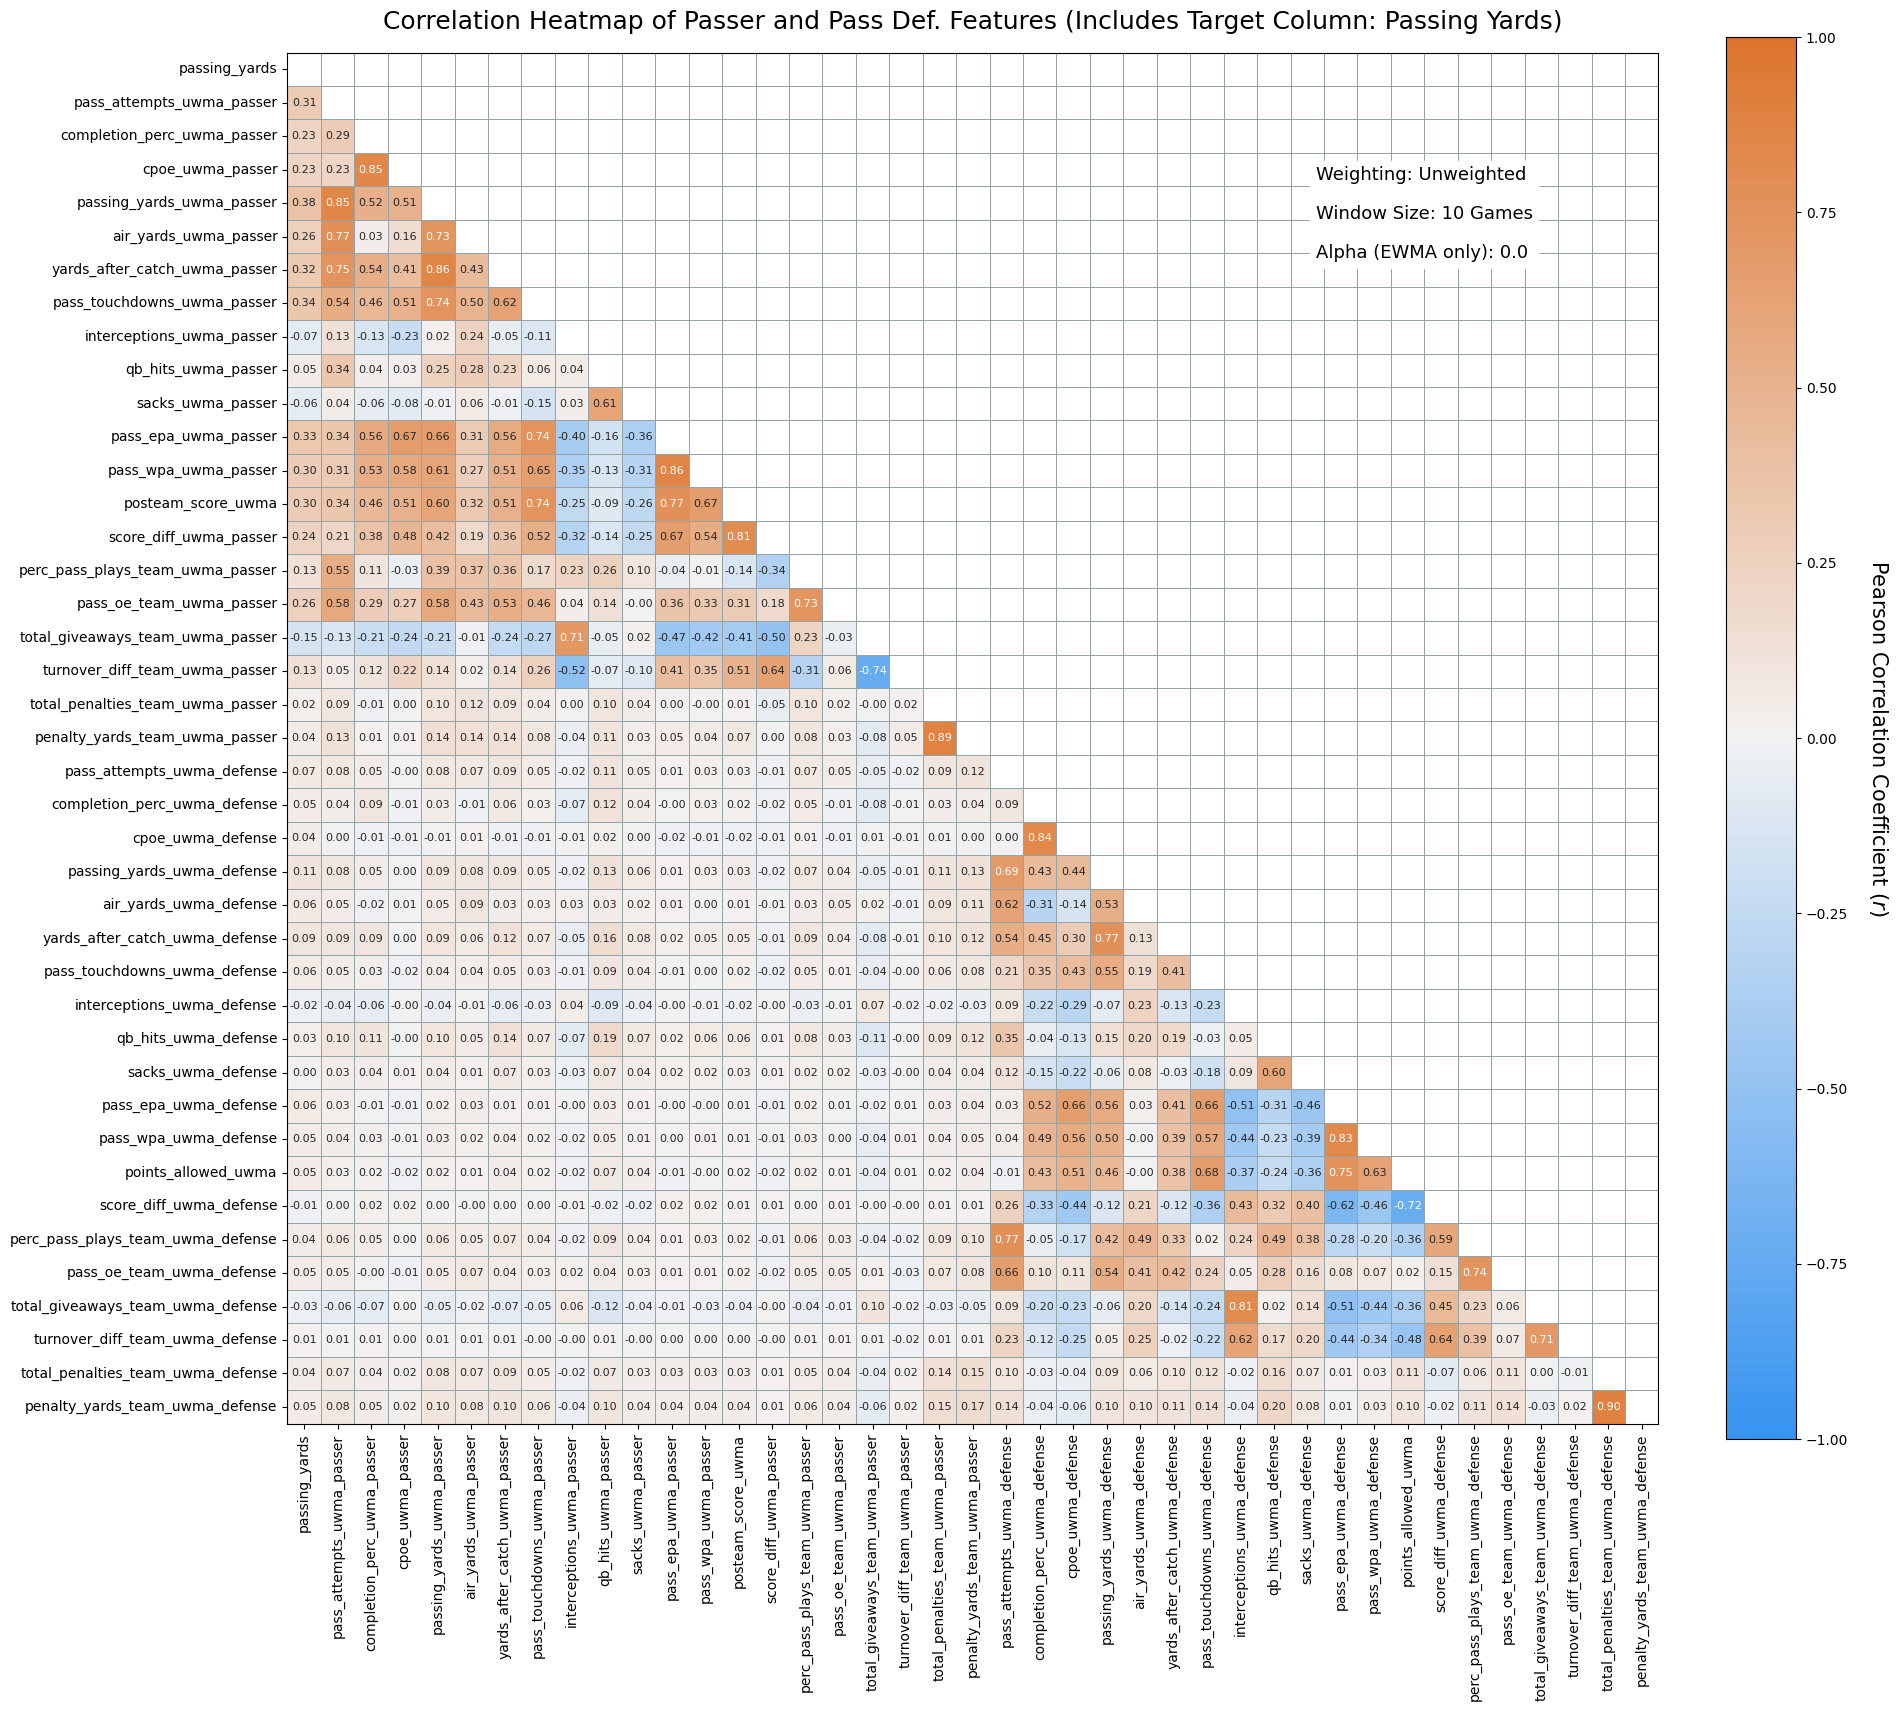

In [32]:
## Create correlation heat map
## Computing pairwise correlation of the columns (excluding NA values)
corrs = final_merged_df.drop(columns=['player_name', 'posteam', 'defteam', 'season', 'week', 'posteam_home', 'defteam_home']).corr(method='pearson')

display(corrs)

mask = np.zeros_like(corrs) ## Returns an array of zeros with the same shape and type as "corrs"
mask[np.triu_indices_from(mask)] = True ## np.triu_indices_from returns the indices for the upper-triangle of "mask"

sns.set_style({"xtick.direction": "out","ytick.direction": "out"})

fig, ax = plt.subplots(figsize=(20,18))

sns.heatmap(
    corrs,
    vmin=-1.,
    vmax=1.,
    center=0.,
    annot=True,
    annot_kws={"fontsize": 8},
    fmt='.2f',
    linewidths=0.5,
    linecolor='xkcd:cool grey',
    cmap=sns.diverging_palette(250, 30, l=60, s=90, sep=1, center='light', as_cmap=True),
    cbar=True,
    cbar_kws={'shrink': 0.9, 'pad': 0.04},
    square=True,
    mask=mask
)

sns.despine(top=False, left=False, right=False, bottom=False)

ax.collections[0].colorbar.set_label('Pearson Correlation Coefficient ($r$)', labelpad=30, rotation=270, fontsize=15)

alpha = smoothing_factor.value

if weighting.value == 'Exponential' and alpha == 0.0:
    alpha = round(2. / (games_to_avg.value + 1.), 3)

ax.text(
    0.75, 
    0.85, 
    'Weighting: {}\nWindow Size: {} Games\nAlpha (EWMA only): {}'.format(weighting.value, games_to_avg.value, alpha),
    transform=ax.transAxes,
    fontsize=13,
    backgroundcolor='white',
    linespacing=2.5
)

ax.set_title('Correlation Heatmap of Passer and Pass Def. Features (Includes Target Column: Passing Yards)', fontsize=18, pad=17)

plt.tight_layout()

plt.savefig(
    'player_passing_yards_feature_correlation_heatmap_passer_passD_{}_N{}_alpha{}.pdf'
    .format(weighting.value, games_to_avg.value, alpha)
)

plt.show()

### Machine Learning Model to Predict Quarterback Passing Yards<br>

Here I want to set up, tune, and compare a couple of different ensemble regression models.<br>
I will compare Random Forest regression and Histogram-based Gradient Boosted regression to see which performs better.  
<br>
Interestingly, the target "passing yards" does not seem to be strongly correlated with any UWMA or EWMA feature as seen in the heatmap above.